# Audio Hybrid Neuroevolution Notebook

This notebook implements a hybrid neuroevolution process for audio classification (Parkinson detection). The system combines genetic algorithms with 1D convolutional neural networks to evolve optimal architectures for audio processing.

## Main Features:
- **Hybrid genetic algorithm**: Combines architecture and weight evolution
- **1D Convolutional Networks**: Optimized for audio waveform processing
- **Parallel 5-Fold Cross-Validation**: Each individual is evaluated on all 5 folds IN PARALLEL (fitness = average accuracy)
- **Multi-threading**: Folds are trained simultaneously in separate threads for faster evaluation
- **Adaptive mutation**: Dynamic mutation rate based on population diversity
- **Audio dataset support**: Loads .npy files with train/val/test splits
- **Intelligent stopping criteria**: By target fitness or maximum generations
- **Complete visualization**: Shows progress and final best architecture

## Objectives:
1. Create initial population of 1D CNN architectures
2. Evaluate fitness of each individual using **parallel 5-fold CV** (robust and faster with threading)
3. Select best architectures (elitism)
4. Apply crossover and mutation to create new generation
5. Repeat process until convergence
6. Display the best architecture found for Parkinson classification

**✅ Performance**: Multi-threaded 5-fold CV provides robustness against overfitting while being much faster than sequential training.


---
## ✨ CONFIGURACIÓN ACTUAL DEL DATASET ✨

**Dataset configurado**: `files_all_real_syn_n` (Datos Reales + Sintéticos Mezclados)

Este notebook está configurado para usar el **nuevo dataset** que combina:
- 🎵 **Datos Reales**: Audios originales de pacientes  
- 🤖 **Datos Sintéticos**: Audios generados por GANs (BigVSAN 40_1e5)

**Ventajas de este dataset**:
- Mayor diversidad de datos para entrenamiento
- Combina la autenticidad de datos reales con la variedad de datos generados
- Ideal para mejorar la generalización del modelo
- Estratificación balanceada entre clases (control/patológico)

**🚀 Parallel 5-Fold Cross-Validation durante la Evolución**: 
- **CADA** individuo se evalúa en **TODOS** los 5 folds **EN PARALELO**
- Los 5 folds se entrenan **simultáneamente** en threads separados
- El fitness es el **promedio** de accuracy de los 5 folds
- ✅ **Mucho más rápido** que entrenamiento secuencial
- ✅ **Más robusto** - evita sobreajuste a un fold específico

**📊 Evaluación Final**: 
- Al terminar la evolución, la mejor arquitectura se vuelve a evaluar con 5-fold CV
- Se reportan métricas completas (accuracy, sensitivity, specificity, F1, AUC)

Para cambiar el dataset, modifica los parámetros `dataset_id` y `fold_id` en la celda de **Configuración** (Sección 2).

---

## 1. Required Libraries Import

In [1]:
# Install all necessary libraries
import subprocess
import sys

def install_package(package):
    """Installs a package using pip if not available."""
    try:
        __import__(package.split('==')[0].split('[')[0])
        print(f"OK {package.split('==')[0]} is already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"OK {package} installed correctly")

# List of required packages
required_packages = [
    "torch>=2.0.0",
    "torchvision>=0.15.0",
    "numpy>=1.21.0",
    "matplotlib>=3.5.0",
    "seaborn>=0.11.0",
    "tqdm>=4.64.0",
    "jupyter>=1.0.0",
    "ipywidgets>=8.0.0"
]

print("Starting dependency installation for Hybrid Neuroevolution...")
print("=" * 60)

for package in required_packages:
    install_package(package)

print("\nAll dependencies have been verified/installed")
print("Restart the kernel if this is the first time installing torch")
print("=" * 60)

# Verify PyTorch installation
try:
    import torch
    print(f"\nPyTorch {torch.__version__} installed correctly")
    print(f"CUDA available: {'Yes' if torch.cuda.is_available() else 'No'}")
    if torch.cuda.is_available():
        print(f"GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")
except ImportError:
    print("ERROR: PyTorch could not be installed correctly")
    print("Try installing manually with: pip install torch torchvision")

Starting dependency installation for Hybrid Neuroevolution...
Installing torch>=2.0.0...


OK torch>=2.0.0 installed correctly
Installing torchvision>=0.15.0...


OK torchvision>=0.15.0 installed correctly
Installing numpy>=1.21.0...


OK numpy>=1.21.0 installed correctly
Installing matplotlib>=3.5.0...


OK matplotlib>=3.5.0 installed correctly
Installing seaborn>=0.11.0...


OK seaborn>=0.11.0 installed correctly
Installing tqdm>=4.64.0...


OK tqdm>=4.64.0 installed correctly
Installing jupyter>=1.0.0...


OK jupyter>=1.0.0 installed correctly
Installing ipywidgets>=8.0.0...


OK ipywidgets>=8.0.0 installed correctly

All dependencies have been verified/installed
Restart the kernel if this is the first time installing torch

PyTorch 2.8.0+cu128 installed correctly
CUDA available: Yes
GPU detected: NVIDIA A100-PCIE-40GB MIG 7g.40gb
GPU memory: 39 GB


In [2]:
# Main imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Scientific libraries
import numpy as np
import random
import copy
import json
import os
from typing import Dict, List, Tuple, Any
from datetime import datetime
import uuid

# Threading for parallel fold training
import threading
from queue import Queue
from concurrent.futures import ThreadPoolExecutor, as_completed

# Visualization and progress
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Configure seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Configure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device configured: {device}")
print(f"PyTorch version: {torch.__version__}")

# Suppress unnecessary warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

Device configured: cuda
PyTorch version: 2.8.0+cu128


## 2. System Configuration and Parameters

In [3]:
# Main genetic algorithm configuration (updated for adaptive mutation & moderate elitism)
CONFIG = {
    # Genetic algorithm parameters
    'population_size': 20,            # Population size
    'max_generations': 100,            # Maximum number of generations
    'fitness_threshold': 80.0,        # Target fitness (% accuracy) - Adjusted for audio

    # Adaptive mutation parameters
    'base_mutation_rate': 0.25,       # Starting mutation rate (moderate)
    'mutation_rate_min': 0.10,        # Lower bound for adaptive mutation
    'mutation_rate_max': 0.80,        # Upper bound for adaptive mutation
    'current_mutation_rate': 0.25,    # Will be updated dynamically each generation

    'crossover_rate': 0.99,           # Crossover rate
    'elite_percentage': 0.2,          # Moderate elitism (20%) instead of 40%

    # Dataset selection (AUDIO ONLY)
    'dataset': 'AUDIO',               # Audio dataset for Parkinson classification

    # Dataset parameters for audio
    'num_channels': 1,                # Input channels (1 for audio waveform)
    'sequence_length': 240000,        # Audio sequence length (will be auto-detected)
    'num_classes': 2,                 # Number of classes (control vs pathological)
    'batch_size': 64,                 # Batch size for audio
    'test_split': 0.2,                # Validation percentage

    # Training parameters
    'num_epochs': 100,                 # Max training epochs per evaluation (may stop earlier)
    'learning_rate': 0.00001,           # Base learning rate
    'early_stopping_patience': 100000,   # Max batches per epoch (quick partial epoch)

    # Epoch-level early stopping
    'epoch_patience': 10,              # Stop if no significant improvement after N evaluations
    'improvement_threshold': 0.01,     # Minimum (absolute) accuracy gain (%) to reset patience

    # Generation-level early stopping 
    'early_stopping_generations': 20, # Stop if no improvement in X generations
    'min_improvement_threshold': 0.01, # Minimum fitness improvement (%) to reset counter

    # Allowed architecture range for 1D Conv
    'min_conv_layers': 1,
    'max_conv_layers': 30,             # Less layers for 1D audio
    'min_fc_layers': 1,
    'max_fc_layers': 10,               # Less FC layers
    'min_filters': 1,
    'max_filters': 256,               # Adjusted for 1D
    'min_fc_nodes': 64,
    'max_fc_nodes': 1024,              # Smaller for audio classification

    # Mutation parameters - Kernel sizes for 1D Conv
    'kernel_size_options': [1, 3, 5, 7, 9, 11, 13, 15],  # Available kernel sizes for Conv1D
    
    # Mutation parameters - Dropout range
    'min_dropout': 0.2,               # Minimum dropout rate
    'max_dropout': 0.6,               # Maximum dropout rate
    
    # Mutation parameters - Learning rate options
    'learning_rate_options': [0.001, 0.0005, 0.0001, 0.00005, 0.00001, 0.01, 0.1, 0.00001 ],  # Available learning rates
    
    # Mutation parameters - Normalization type weights
    'normalization_batch_weight': 0.8,  # Probability to use batch normalization
    'normalization_layer_weight': 0.2,  # Probability to use layer normalization

    # Audio dataset configuration (OS-independent paths)
    
    'dataset_id': '40_1e5_N',   # Dataset ID - Mixed real + synthetic data
    'fold_id': '40_1e5_N',      # Fold ID for files
    'num_folds': 5,                   # Number of folds (all used during evolution)
    'data_path': os.path.join('data', 'sets', 'folds_5'),  # OS-independent path
    'fold_files_subdirectory': 'files_real_40_1e5_N',  # Subdirectory containing fold .npy files
    'normalization': {'mean': (0.0,), 'std': (1.0,)}  # Audio normalization
}

# Activation function mapping
ACTIVATION_FUNCTIONS = {
    'relu': nn.ReLU,
    'leaky_relu': nn.LeakyReLU,
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'selu': nn.SELU,
}

# Optimizer mapping
OPTIMIZERS = {
    'adam': optim.Adam,
    'adamw': optim.AdamW,
    'sgd': optim.SGD,
    'rmsprop': optim.RMSprop,
}

print("Configuration loaded (adaptive mutation enabled, 1D Conv for audio):")
print(f"   Dataset: Audio (Parkinson Classification)")
for key, value in CONFIG.items():
    if key not in ['normalization']:  # Hide normalization details
        print(f"   {key}: {value}")
print(f"\nAvailable activation functions: {list(ACTIVATION_FUNCTIONS.keys())}")
print(f"Available optimizers: {list(OPTIMIZERS.keys())}")
print(f"\nOS-independent path configured: {CONFIG['data_path']}")


Configuration loaded (adaptive mutation enabled, 1D Conv for audio):
   Dataset: Audio (Parkinson Classification)
   population_size: 20
   max_generations: 100
   fitness_threshold: 80.0
   base_mutation_rate: 0.25
   mutation_rate_min: 0.1
   mutation_rate_max: 0.8
   current_mutation_rate: 0.25
   crossover_rate: 0.99
   elite_percentage: 0.2
   dataset: AUDIO
   num_channels: 1
   sequence_length: 240000
   num_classes: 2
   batch_size: 64
   test_split: 0.2
   num_epochs: 100
   learning_rate: 1e-05
   early_stopping_patience: 100000
   epoch_patience: 10
   improvement_threshold: 0.01
   early_stopping_generations: 20
   min_improvement_threshold: 0.01
   min_conv_layers: 1
   max_conv_layers: 30
   min_fc_layers: 1
   max_fc_layers: 10
   min_filters: 1
   max_filters: 256
   min_fc_nodes: 64
   max_fc_nodes: 1024
   kernel_size_options: [1, 3, 5, 7, 9, 11, 13, 15]
   min_dropout: 0.2
   max_dropout: 0.6
   learning_rate_options: [0.001, 0.0005, 0.0001, 5e-05, 1e-05, 0.01, 0.1, 

### 📋 Parámetros de Mutación Configurables

**Todos los parámetros de mutación ahora son configurables desde `CONFIG`**:

#### Kernel Sizes (Tamaños de kernel para Conv1D)
- **`kernel_size_options`**: `[3, 5, 7, 9, 11, 13, 15]`
  - Opciones disponibles para los tamaños de kernel en capas convolucionales 1D
  - Se usa tanto en la creación inicial como en la mutación

#### Dropout Range (Rango de dropout)
- **`min_dropout`**: `0.2` - Tasa mínima de dropout
- **`max_dropout`**: `0.6` - Tasa máxima de dropout
  - Durante la creación y mutación, el dropout se selecciona aleatoriamente dentro de este rango

#### Learning Rate Options (Opciones de learning rate)
- **`learning_rate_options`**: `[0.001, 0.0005, 0.0001, 0.00005, 0.00001]`
  - Opciones disponibles para el learning rate
  - Se selecciona aleatoriamente de esta lista durante creación y mutación

#### Normalization Type Weights (Pesos para tipo de normalización)
- **`normalization_batch_weight`**: `0.8` - Probabilidad de usar batch normalization (80%)
- **`normalization_layer_weight`**: `0.2` - Probabilidad de usar layer normalization (20%)
  - Durante la mutación, se selecciona el tipo de normalización con estas probabilidades

✅ **Beneficio**: Ahora puedes ajustar todos estos parámetros desde un solo lugar (CONFIG) sin modificar las funciones de mutación o creación de genomas.

### Información sobre el Dataset de Audio

**Dataset de Audio para Clasificación de Parkinson**: 
- Archivos de audio de voz (clasificación Parkinson)
- Datos 1D de forma de onda procesada
- Estructura: archivos .npy con train/val/test splits
- Dificultad: **Alta** - Clasificación médica
- Fitness objetivo recomendado: >85%
- Clases: Control vs Pathological
- Formato de archivos: `{data_path}/files_{fold_id}/X_train_{dataset_id}_fold_{fold}.npy`
- Arquitectura: Conv1D -> BatchNorm1D -> Activation -> MaxPool1D -> FC Layers

**Configuración del Dataset:**
- Modifica los parámetros en la celda de configuración:
  - `dataset_id`: ID del dataset (ej: 'all_real_syn_n')
  - `fold_id`: ID de la carpeta de folds (ej: 'all_real_syn_n')
  - `data_path`: Ruta base a los datos (usa `os.path.join` para compatibilidad multiplataforma)

**🔄 Uso de 5-Fold CV:**
- **Durante la evolución**: Cada individuo se evalúa en los 5 folds automáticamente
- **No se necesita** especificar `current_fold` (se usan todos)
- El fitness es el **promedio** de los 5 folds

**Nota sobre Rutas:**
- Las rutas son **independientes del sistema operativo** (Windows/Linux/Mac)
- Usa `os.path.join()` para construir rutas compatibles
- Ejemplo: `os.path.join('data', 'sets', 'folds_5')` funciona en cualquier OS

---

### Tipos de Carpetas de Folds Disponibles (generadas por `create_5_folds.ipynb`)

El notebook `generating_csv/create_5_folds.ipynb` genera **5 tipos de carpetas** con diferentes combinaciones de datos **reales** y **sintéticos** (generados por GANs) para experimentación:

#### 1. **`files_real_N`** - Solo Datos Reales
   - **Train**: Datos reales (`test_together_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Baseline con datos 100% reales
   - **fold_id**: `'real_N'`
   - **dataset_id**: `'real_N'`

#### 2. **`files_real_40_1e5_N`** - Entrenamiento Sintético, Test Real
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Evaluar si modelos entrenados con sintéticos generalizan a datos reales
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 3. **`files_syn_40_1e5_N`** - Solo Datos Sintéticos (mismo conjunto)
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Uso**: Evaluar capacidad del modelo con datos 100% sintéticos
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 4. **`files_syn_1_N`** - Entrenamiento Sintético, Test Sintético Diferente
   - **Train**: Datos sintéticos (`generated_together_train_40_1e5_N`)
   - **Test**: Datos sintéticos diferentes (`test_together_syn_1_N`)
   - **Uso**: Evaluar generalización entre diferentes conjuntos sintéticos
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 5. **`files_syn_all_N`** - Solo Datos Reales (mal nombrado probablemente)
   - **Train**: Datos reales (`test_together_N`)
   - **Test**: Datos reales (`test_together_N`)
   - **Uso**: Similar a `files_real_N` (posible duplicado o error de nomenclatura)
   - **fold_id**: `'40_1e5_N'`
   - **dataset_id**: `'40_1e5_N'`

#### 6. **`files_all_real_syn_n`** - ✨ Datos Reales + Sintéticos Mezclados ✨ **(NUEVO)**
   - **Train**: Datos reales + sintéticos mezclados
   - **Validation**: Datos reales + sintéticos mezclados
   - **Test**: Datos reales + sintéticos mezclados
   - **Uso**: Entrenar y evaluar con una mezcla equilibrada de datos reales y generados por GANs
   - **fold_id**: `'all_real_syn_n'`
   - **dataset_id**: `'all_real_syn_n'`
   - **Ventajas**: Combina diversidad de datos sintéticos con autenticidad de datos reales
   - **Configuración actual**: 🔵 **ESTE ES EL DATASET CONFIGURADO POR DEFECTO**

**Nota**: Cada carpeta contiene 5 folds de validación cruzada con:
- `X_train_{dataset_id}_fold_{1-5}.npy` y `y_train_{dataset_id}_fold_{1-5}.npy`
- `X_val_{dataset_id}_fold_{1-5}.npy` y `y_val_{dataset_id}_fold_{1-5}.npy`
- `X_test_{dataset_id}_fold_{1-5}.npy` y `y_test_{dataset_id}_fold_{1-5}.npy`

## 3. Dataset Loading and Preprocessing

In [4]:
def load_dataset(config: dict) -> Tuple[DataLoader, DataLoader]:
    """
    Loads the audio dataset according to configuration.
    Returns train_loader and test_loader.
    """
    
    print(f"Loading audio dataset from: {config['data_path']}")
    print(f"Dataset ID: {config['dataset_id']}, Fold: {config['current_fold']}")
    
    # Construct paths following ResNet convention
    fold_files_directory = os.path.join(
        config['data_path'], 
        f"files_real_{config['fold_id']}"
    )
    
    # Check if directory exists
    print(f"\nChecking data directory...")
    print(f"   Looking for: {os.path.abspath(fold_files_directory)}")
    
    if not os.path.exists(fold_files_directory):
        print(f"\n❌ ERROR: Directory not found!")
        print(f"   Expected: {os.path.abspath(fold_files_directory)}")
        
        # Try to find the correct path
        possible_paths = [
            os.path.join('..', 'data', 'sets', 'folds_5', f"files_real_{config['fold_id']}"),
            os.path.join('data', 'sets', 'folds_5', f"files_real_{config['fold_id']}"),
            os.path.join('.', 'data', 'sets', 'folds_5', f"files_real_{config['fold_id']}"),
        ]
        
        print(f"\nSearching for data in alternative locations:")
        for path in possible_paths:
            abs_path = os.path.abspath(path)
            exists = os.path.exists(path)
            print(f"   {'✓' if exists else '✗'} {abs_path}")
            if exists:
                fold_files_directory = path
                print(f"\n✓ Found data at: {os.path.abspath(fold_files_directory)}")
                break
        else:
            raise FileNotFoundError(
                f"\n❌ Could not find data directory!\n"
                f"   Tried paths:\n" + 
                "\n".join([f"      - {os.path.abspath(p)}" for p in possible_paths]) +
                f"\n\n   Please check:\n"
                f"      1. CONFIG['data_path'] is correct\n"
                f"      2. The data files exist\n"
                f"      3. The fold_files_subdirectory '{config['fold_files_subdirectory']}' is correct\n"
            )
    else:
        print(f"   ✓ Directory found: {os.path.abspath(fold_files_directory)}")
    
def load_dataset(config: dict):
    """
    Verifica que los datos existen y carga el primer fold para detectar sequence_length.
    Durante la evolución, cada individuo cargará todos los folds automáticamente.
    
    Args:
        config: Diccionario de configuración
    
    Returns:
        None (solo actualiza config['sequence_length'])
    """
    print("\n" + "="*60)
    print("VERIFICANDO DISPONIBILIDAD DE DATOS")
    print("="*60)
    print(f"Dataset ID: {config['dataset_id']}, Verificando los 5 folds...")
    
    # Build directory path using the configured subdirectory
    fold_files_directory = os.path.join(
        config['data_path'], 
        config['fold_files_subdirectory']
    )
    
    print(f"   Looking for: {os.path.abspath(fold_files_directory)}")
    
    # If directory not found, try alternative locations
    if not os.path.exists(fold_files_directory):
        possible_paths = [
            os.path.join('..', 'data', 'sets', 'folds_5', config['fold_files_subdirectory']),
            os.path.join('data', 'sets', 'folds_5', config['fold_files_subdirectory']),
            os.path.join('.', 'data', 'sets', 'folds_5', config['fold_files_subdirectory']),
        ]
        
        print(f"\nSearching for data in alternative locations:")
        for path in possible_paths:
            abs_path = os.path.abspath(path)
            exists = os.path.exists(path)
            print(f"   {'✓' if exists else '✗'} {abs_path}")
            if exists:
                fold_files_directory = path
                print(f"\n✓ Found data at: {os.path.abspath(fold_files_directory)}")
                break
        else:
            raise FileNotFoundError(
                f"\n❌ Could not find data directory!\n"
                f"   Tried paths:\n" + 
                "\n".join([f"      - {os.path.abspath(p)}" for p in possible_paths]) +
                f"\n\n   Please check:\n"
                f"      1. CONFIG['data_path'] is correct\n"
                f"      2. The data files exist\n"
                f"      3. The fold_id '{config['fold_id']}' is correct\n"
            )
    else:
        print(f"   ✓ Directory found: {os.path.abspath(fold_files_directory)}")
    
    dataset_id = config['dataset_id']
    
    # Check that all 5 folds exist
    print(f"\nChecking for all 5 folds...")
    all_folds_ok = True
    
    for fold_num in range(1, 6):
        required_files = [
            f'X_train_{dataset_id}_fold_{fold_num}.npy',
            f'y_train_{dataset_id}_fold_{fold_num}.npy',
            f'X_val_{dataset_id}_fold_{fold_num}.npy',
            f'y_val_{dataset_id}_fold_{fold_num}.npy',
            f'X_test_{dataset_id}_fold_{fold_num}.npy',
            f'y_test_{dataset_id}_fold_{fold_num}.npy',
        ]
        
        fold_ok = True
        for filename in required_files:
            filepath = os.path.join(fold_files_directory, filename)
            if not os.path.exists(filepath):
                fold_ok = False
                all_folds_ok = False
                print(f"   ✗ Fold {fold_num}: Missing {filename}")
                break
        
        if fold_ok:
            print(f"   ✓ Fold {fold_num}: All files present")
    
    if not all_folds_ok:
        raise FileNotFoundError(
            f"\n❌ Some fold files are missing!\n"
            f"   Please ensure all 5 folds have complete data files.\n"
            f"   dataset_id: '{dataset_id}'\n"
        )
    
    print(f"\n✓ All 5 folds verified successfully!")
    
    # Load first fold to detect sequence_length
    print(f"\nLoading Fold 1 to detect sequence length...")
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_1.npy'))
    
    print(f"   Train samples: {x_train.shape}")
    
    # Update sequence length from actual data
    if len(x_train.shape) == 2:  # (samples, sequence_length)
        config['sequence_length'] = x_train.shape[1]
    elif len(x_train.shape) == 3:  # Already (samples, channels, sequence_length)
        config['sequence_length'] = x_train.shape[2]
    
    print(f"   Sequence length detected: {config['sequence_length']}")
    print(f"\n✓ Dataset verification complete!")
    print(f"   During evolution, each individual will train on all 5 folds.")
    print("="*60)

# Verify dataset availability
load_dataset(CONFIG)

print(f"\n{'='*60}")
print("DATASET READY FOR 5-FOLD CROSS-VALIDATION")
print(f"{'='*60}")
print(f"   Sequence length: {CONFIG['sequence_length']}")
print(f"   Input channels: {CONFIG['num_channels']}")
print(f"   Number of classes: {CONFIG['num_classes']}")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Audio classification task: Control (0) vs Pathological (1)")
print(f"\n   ⚠️ Each individual will be evaluated on ALL 5 folds")
print(f"   ⚠️ This makes evolution ~5x slower but much more robust")




VERIFICANDO DISPONIBILIDAD DE DATOS
Dataset ID: 40_1e5_N, Verificando los 5 folds...
   Looking for: /home/jovyan/audio_test/data/sets/folds_5/files_real_40_1e5_N
   ✓ Directory found: /home/jovyan/audio_test/data/sets/folds_5/files_real_40_1e5_N

Checking for all 5 folds...
   ✓ Fold 1: All files present
   ✓ Fold 2: All files present
   ✓ Fold 3: All files present
   ✓ Fold 4: All files present
   ✓ Fold 5: All files present

✓ All 5 folds verified successfully!

Loading Fold 1 to detect sequence length...
   Train samples: (7200, 11520)
   Sequence length detected: 11520

✓ Dataset verification complete!
   During evolution, each individual will train on all 5 folds.

DATASET READY FOR 5-FOLD CROSS-VALIDATION
   Sequence length: 11520
   Input channels: 1
   Number of classes: 2
   Batch size: 64
   Audio classification task: Control (0) vs Pathological (1)

   ⚠️ Each individual will be evaluated on ALL 5 folds
   ⚠️ This makes evolution ~5x slower but much more robust


## 4. Neural Network Architecture Definition

In [5]:
class EvolvableCNN(nn.Module):
    """
    Evolvable CNN class for 1D audio processing.
    Uses Conv1D layers for audio/sequential data.
    """
    
    def __init__(self, genome: dict, config: dict):
        super(EvolvableCNN, self).__init__()
        self.genome = genome
        self.config = config
        
        # Validate and fix genome structure before building
        self._validate_genome()
        
        # Build convolutional layers (1D for audio)
        self.conv_layers = self._build_conv_layers()
        
        # Calculate output size after convolutions
        self.conv_output_size = self._calculate_conv_output_size()
        
        # Build fully connected layers
        self.fc_layers = self._build_fc_layers()
    
    def _validate_genome(self):
        """Validates and fixes genome structure to ensure consistency."""
        # Ensure conv-related lists match num_conv_layers
        num_conv = self.genome['num_conv_layers']
        
        if len(self.genome['filters']) != num_conv:
            # Fix filters list
            self.genome['filters'] = self.genome['filters'][:num_conv]
            while len(self.genome['filters']) < num_conv:
                self.genome['filters'].append(
                    random.randint(self.config['min_filters'], self.config['max_filters'])
                )
        
        if len(self.genome['kernel_sizes']) != num_conv:
            # Fix kernel_sizes list
            self.genome['kernel_sizes'] = self.genome['kernel_sizes'][:num_conv]
            while len(self.genome['kernel_sizes']) < num_conv:
                self.genome['kernel_sizes'].append(
                    random.choice(self.config['kernel_size_options'])
                )
        
        # Ensure fc-related lists match num_fc_layers
        num_fc = self.genome['num_fc_layers']
        
        if len(self.genome['fc_nodes']) != num_fc:
            # Fix fc_nodes list
            self.genome['fc_nodes'] = self.genome['fc_nodes'][:num_fc]
            while len(self.genome['fc_nodes']) < num_fc:
                self.genome['fc_nodes'].append(
                    random.randint(self.config['min_fc_nodes'], self.config['max_fc_nodes'])
                )
        
    def _build_conv_layers(self) -> nn.ModuleList:
        """Builds 1D convolutional layers according to genome."""
        layers = nn.ModuleList()
        
        in_channels = self.config['num_channels']
        normalization_type = self.genome.get('normalization_type', 'batch')  # Default to batch normalization

        for i in range(self.genome['num_conv_layers']):
            # Safe access with validation
            if i >= len(self.genome['filters']) or i >= len(self.genome['kernel_sizes']):
                raise IndexError(
                    f"Genome list mismatch: i={i}, num_conv_layers={self.genome['num_conv_layers']}, "
                    f"filters_len={len(self.genome['filters'])}, kernel_sizes_len={len(self.genome['kernel_sizes'])}"
                )
            
            out_channels = self.genome['filters'][i]
            kernel_size = self.genome['kernel_sizes'][i]
            
            # Ensure kernel size is odd and reasonable for 1D
            kernel_size = max(3, kernel_size if kernel_size % 2 == 1 else kernel_size + 1)
            padding = kernel_size // 2
            
            # 1D Convolutional layer
            conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
            layers.append(conv)
            
            # Normalization layer (Layer Normalization or Batch Normalization)
            if normalization_type == 'layer':
                # Layer Normalization: normaliza sobre features, no sobre batch
                # Para Conv1d output de shape (batch, channels, length), normalizamos los channels
                layers.append(nn.LayerNorm(out_channels))
            else:
                # Batch normalization (default)
                layers.append(nn.BatchNorm1d(out_channels))
            
            # Activation function
            activation_name = self.genome['activations'][i % len(self.genome['activations'])]
            activation_func = ACTIVATION_FUNCTIONS[activation_name]()
            layers.append(activation_func)
            
            # Max pooling (1D) - reduce sequence length
            pool_size = 2 if i < self.genome['num_conv_layers'] - 1 else 2
            layers.append(nn.MaxPool1d(pool_size, pool_size))
            
            # Optional dropout after pooling
            if i < self.genome['num_conv_layers'] - 1:
                layers.append(nn.Dropout(0.1))
            
            in_channels = out_channels
            
        return layers
    
    def _calculate_conv_output_size(self) -> int:
        """
        Calculates output size after convolutional layers.
        Raises ValueError if the architecture produces invalid dimensions.
        """
        # Create dummy tensor to calculate size
        dummy_input = torch.zeros(1, self.config['num_channels'], 
                                 self.config['sequence_length'])
        
        # Pass through convolutional layers with validation
        x = dummy_input
        normalization_type = self.genome.get('normalization_type', 'batch')
        
        try:
            # Set model to eval mode to avoid BatchNorm training issues with batch_size=1
            self.eval()
            
            for layer in self.conv_layers:
                # Check dimensions before BatchNorm layers
                if isinstance(layer, nn.BatchNorm1d) and normalization_type == 'batch':
                    # Check if spatial dimension is too small for BatchNorm
                    if x.shape[2] <= 1:  # spatial dimension
                        raise ValueError(
                            f"Invalid architecture: spatial dimension too small ({x.shape[2]}) "
                            f"for BatchNorm1d. This genome produces architectures that are too deep. "
                            f"Genome: num_conv_layers={self.genome['num_conv_layers']}, "
                            f"sequence_length={self.config['sequence_length']}"
                        )
                
                x = layer(x)
                
                # Additional check after each layer
                if x.shape[2] < 1:
                    raise ValueError(
                        f"Invalid architecture: sequence length became zero or negative. "
                        f"Current shape: {x.shape}, "
                        f"Genome: num_conv_layers={self.genome['num_conv_layers']}"
                    )
            
            # Back to training mode
            self.train()
            
        except ValueError as e:
            # Re-raise our custom validation errors
            raise e
        except Exception as e:
            # Catch any other errors during size calculation
            raise ValueError(
                f"Error calculating conv output size: {str(e)}. "
                f"Genome may produce invalid architecture. "
                f"num_conv_layers={self.genome['num_conv_layers']}, "
                f"sequence_length={self.config['sequence_length']}"
            )
        
        # Flatten and get size
        flattened_size = x.view(-1).shape[0]
        
        # Ensure we have a reasonable output size
        if flattened_size < 1:
            raise ValueError(
                f"Invalid architecture: flattened size is {flattened_size}. "
                f"The architecture is too aggressive in dimension reduction."
            )
        
        return flattened_size
    
    def _build_fc_layers(self) -> nn.ModuleList:
        """Builds fully connected layers."""
        layers = nn.ModuleList()
        
        input_size = self.conv_output_size
        normalization_type = self.genome.get('normalization_type', 'batch')  # Default to batch normalization

        for i in range(self.genome['num_fc_layers']):
            # Safe access with validation
            if i >= len(self.genome['fc_nodes']):
                raise IndexError(
                    f"Genome list mismatch: i={i}, num_fc_layers={self.genome['num_fc_layers']}, "
                    f"fc_nodes_len={len(self.genome['fc_nodes'])}"
                )
            
            output_size = self.genome['fc_nodes'][i]
            
            # Linear layer
            layers.append(nn.Linear(input_size, output_size))
            
            # Normalization layer (Layer Normalization or Batch Normalization)
            if normalization_type == 'layer':
                # Layer Normalization for FC layers
                layers.append(nn.LayerNorm(output_size))
            else:
                # Batch normalization for FC layers (default)
                layers.append(nn.BatchNorm1d(output_size))
            
            # Activation
            layers.append(nn.ReLU())
            
            # Dropout if not last layer
            if i < self.genome['num_fc_layers'] - 1:
                layers.append(nn.Dropout(self.genome['dropout_rate']))
            
            input_size = output_size
        
        # Final classification layer
        layers.append(nn.Linear(input_size, self.config['num_classes']))
        
        return layers
    
    def forward(self, x):
        """Forward pass of the network."""
        # Ensure input is in correct format for Conv1d
        # Expected: (batch, channels, sequence_length)
        if len(x.shape) == 2:  # (batch, sequence)
            x = x.unsqueeze(1)  # Add channel dimension
        
        # Convolutional layers
        for layer in self.conv_layers:
            x = layer(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        for layer in self.fc_layers:
            x = layer(x)
        
        return x
    
    def get_architecture_summary(self) -> str:
        """Returns an architecture summary."""
        summary = []
        summary.append(f"Conv1D Layers: {self.genome['num_conv_layers']}")
        summary.append(f"Filters: {self.genome['filters']}")
        summary.append(f"Kernel Sizes: {self.genome['kernel_sizes']}")
        summary.append(f"FC Layers: {self.genome['num_fc_layers']}")
        summary.append(f"FC Nodes: {self.genome['fc_nodes']}")
        summary.append(f"Activations: {self.genome['activations']}")
        summary.append(f"Normalization: {self.genome.get('normalization_type', 'batch')}")
        summary.append(f"Dropout: {self.genome['dropout_rate']:.3f}")
        summary.append(f"Optimizer: {self.genome['optimizer']}")
        summary.append(f"Learning Rate: {self.genome['learning_rate']:.4f}")
        return " | ".join(summary)

print("EvolvableCNN class defined correctly (Conv1D for audio with architecture validation)")


EvolvableCNN class defined correctly (Conv1D for audio with architecture validation)


## 5. Genetic Algorithm Components

### 5.1 Genome Creation

In [6]:
def create_random_genome(config: dict) -> dict:
    """
    Creates a random genome within specified ranges (optimized for 1D audio, using configurable parameters).
    Ensures the genome will produce a valid architecture.
    """
    max_attempts = 100
    attempt = 0
    
    while attempt < max_attempts:
        # Calculate maximum safe conv layers based on sequence length
        sequence_length = config['sequence_length']
        min_required_length = 4
        max_safe_conv_layers = int(np.log2(sequence_length / min_required_length))
        
        # Limit conv layers to safe maximum
        safe_max_conv = min(config['max_conv_layers'], max_safe_conv_layers)
        
        # Number of layers
        num_conv_layers = random.randint(config['min_conv_layers'], safe_max_conv)
        num_fc_layers = random.randint(config['min_fc_layers'], config['max_fc_layers'])

        # Filters for each convolutional layer (progressive increase)
        filters = []
        base_filters = random.randint(config['min_filters'], config['min_filters'] * 2)
        for i in range(num_conv_layers):
            # Gradually increase filters in deeper layers
            layer_filters = min(base_filters * (2 ** i), config['max_filters'])
            filters.append(layer_filters)

        # Kernel sizes (using configured options)
        kernel_sizes = [random.choice(config['kernel_size_options']) for _ in range(num_conv_layers)]

        # Nodes in fully connected layers (progressive decrease)
        fc_nodes = []
        base_fc = random.randint(config['min_fc_nodes'], config['max_fc_nodes'])
        for i in range(num_fc_layers):
            layer_nodes = max(config['min_fc_nodes'], base_fc // (2 ** i))
            fc_nodes.append(layer_nodes)

        # Activation functions for each layer
        activations = [random.choice(list(ACTIVATION_FUNCTIONS.keys())) for _ in range(max(num_conv_layers, num_fc_layers))]

        # Other parameters (using configured ranges and options)
        dropout_rate = random.uniform(config['min_dropout'], config['max_dropout'])
        learning_rate = random.choice(config['learning_rate_options'])
        optimizer = random.choice(list(OPTIMIZERS.keys()))
        normalization_type = 'batch'  # Default to batch normalization

        genome = {
            'num_conv_layers': num_conv_layers,
            'num_fc_layers': num_fc_layers,
            'filters': filters,
            'kernel_sizes': kernel_sizes,
            'fc_nodes': fc_nodes,
            'activations': activations,
            'dropout_rate': dropout_rate,
            'learning_rate': learning_rate,
            'optimizer': optimizer,
            'normalization_type': normalization_type,
            'fitness': 0.0,
            'id': str(uuid.uuid4())[:8]
        }
        
        # Validate genome
        if is_genome_valid(genome, config):
            return genome
        
        attempt += 1
    
    # If we couldn't create a valid genome, create a minimal safe one
    print(f"⚠️ Warning: Could not create random genome after {max_attempts} attempts. Creating minimal safe genome.")
    return {
        'num_conv_layers': 1,
        'num_fc_layers': 1,
        'filters': [32],
        'kernel_sizes': [3],
        'fc_nodes': [64],
        'activations': ['relu', 'relu'],
        'dropout_rate': 0.3,
        'learning_rate': 0.001,
        'optimizer': 'adam',
        'normalization_type': 'batch',
        'fitness': 0.0,
        'id': str(uuid.uuid4())[:8]
    }

print("✓ create_random_genome function defined (using configurable parameters with validation)")


✓ create_random_genome function defined (using configurable parameters with validation)


In [7]:
def validate_and_fix_genome(genome: dict, config: dict) -> dict:
    """
    Validates and fixes a genome to ensure all lists match their corresponding layer counts.
    This prevents IndexError when building the model.
    
    Args:
        genome: The genome to validate
        config: Configuration dictionary with min/max values
    
    Returns:
        Fixed genome with correct list lengths
    """
    # Fix filters and kernel_sizes to match num_conv_layers
    num_conv = genome['num_conv_layers']
    
    # Fix filters list
    if len(genome['filters']) != num_conv:
        genome['filters'] = genome['filters'][:num_conv]
        while len(genome['filters']) < num_conv:
            genome['filters'].append(
                random.randint(config['min_filters'], config['max_filters'])
            )
    
    # Fix kernel_sizes list
    if len(genome['kernel_sizes']) != num_conv:
        genome['kernel_sizes'] = genome['kernel_sizes'][:num_conv]
        while len(genome['kernel_sizes']) < num_conv:
            genome['kernel_sizes'].append(
                random.choice(config['kernel_size_options'])
            )
    
    # Fix fc_nodes to match num_fc_layers
    num_fc = genome['num_fc_layers']
    
    if len(genome['fc_nodes']) != num_fc:
        genome['fc_nodes'] = genome['fc_nodes'][:num_fc]
        while len(genome['fc_nodes']) < num_fc:
            genome['fc_nodes'].append(
                random.randint(config['min_fc_nodes'], config['max_fc_nodes'])
            )
    
    return genome

print("✓ validate_and_fix_genome function defined")

✓ validate_and_fix_genome function defined


### 5.2 Genome Mutation

### 5.1.5 Genome Architecture Validation

Esta función valida que un genoma no produzca arquitecturas inválidas que causarían errores con BatchNorm.

**Problema:** BatchNorm1d requiere más de 1 valor en la dimensión espacial. Si tenemos demasiadas capas convolucionales con MaxPooling, la dimensión espacial se reduce a 1 o menos, causando el error:
```
ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 256, 1])
```

**Solución:** Validamos que el número de capas convolucionales no reduzca excesivamente las dimensiones:
- Cada capa convolucional con MaxPool(2) divide la longitud de secuencia por 2
- Necesitamos mantener al menos 4 valores en la dimensión espacial para BatchNorm
- Calculamos el máximo número seguro de capas: `max_safe_conv_layers = log2(sequence_length / 4)`


In [8]:
def is_genome_valid(genome: dict, config: dict) -> bool:
    """
    Validates if a genome will produce a valid architecture.
    Checks if the convolutional layers will reduce dimensions too much.
    
    Args:
        genome: The genome to validate
        config: Configuration dictionary
        
    Returns:
        True if genome is valid, False otherwise
    """
    # Calculate expected output size after all conv layers
    # Each MaxPool layer reduces by factor of 2
    num_conv_layers = genome['num_conv_layers']
    sequence_length = config['sequence_length']
    
    # Each conv layer has a MaxPool that divides by 2
    expected_length = sequence_length / (2 ** num_conv_layers)
    
    # We need at least 2 values for BatchNorm to work properly
    # Use a safety margin
    min_required_length = 4
    
    if expected_length < min_required_length:
        return False
    
    # Also check that we don't have too many conv layers for the sequence length
    max_allowed_conv_layers = int(np.log2(sequence_length / min_required_length))
    
    if num_conv_layers > max_allowed_conv_layers:
        return False
    
    return True

print("✓ is_genome_valid function defined")


✓ is_genome_valid function defined


In [9]:
def mutate_genome(genome: dict, config: dict) -> dict:
    """
    Applies mutation to a genome using adaptive mutation rate and configurable parameters.
    Ensures the mutated genome produces a valid architecture.
    """
    max_attempts = 50
    
    for attempt in range(max_attempts):
        mutated_genome = copy.deepcopy(genome)
        mutation_rate = config['current_mutation_rate']  # adaptive

        # Calculate maximum safe conv layers
        sequence_length = config['sequence_length']
        min_required_length = 4
        max_safe_conv_layers = int(np.log2(sequence_length / min_required_length))
        safe_max_conv = min(config['max_conv_layers'], max_safe_conv_layers)

        # Mutate number of convolutional layers (with safety limit)
        if random.random() < mutation_rate:
            mutated_genome['num_conv_layers'] = random.randint(config['min_conv_layers'], safe_max_conv)

        # Mutate number of FC layers
        if random.random() < mutation_rate:
            mutated_genome['num_fc_layers'] = random.randint(config['min_fc_layers'], config['max_fc_layers'])

        # Validate and fix lists to match layer counts
        mutated_genome = validate_and_fix_genome(mutated_genome, config)

        # Mutate filters
        for i in range(len(mutated_genome['filters'])):
            if random.random() < mutation_rate:
                mutated_genome['filters'][i] = random.randint(config['min_filters'], config['max_filters'])

        # Mutate kernel sizes (using configured options)
        for i in range(len(mutated_genome['kernel_sizes'])):
            if random.random() < mutation_rate:
                mutated_genome['kernel_sizes'][i] = random.choice(config['kernel_size_options'])

        # Mutate FC nodes
        for i in range(len(mutated_genome['fc_nodes'])):
            if random.random() < mutation_rate:
                mutated_genome['fc_nodes'][i] = random.randint(config['min_fc_nodes'], config['max_fc_nodes'])

        # Mutate activation functions
        for i in range(len(mutated_genome['activations'])):
            if random.random() < mutation_rate:
                mutated_genome['activations'][i] = random.choice(list(ACTIVATION_FUNCTIONS.keys()))

        # Mutate dropout (using configured range)
        if random.random() < mutation_rate:
            mutated_genome['dropout_rate'] = random.uniform(config['min_dropout'], config['max_dropout'])

        # Mutate learning rate (using configured options)
        if random.random() < mutation_rate:
            mutated_genome['learning_rate'] = random.choice(config['learning_rate_options'])

        # Mutate optimizer
        if random.random() < mutation_rate:
            mutated_genome['optimizer'] = random.choice(list(OPTIMIZERS.keys()))

        # Mutate normalization type (using configured weights)
        if random.random() < mutation_rate:
            mutated_genome['normalization_type'] = random.choices(
                ['batch', 'layer'], 
                weights=[config['normalization_batch_weight'], config['normalization_layer_weight']]
            )[0]

        mutated_genome['id'] = str(uuid.uuid4())[:8]
        mutated_genome['fitness'] = 0.0
        
        # Final validation to ensure consistency
        mutated_genome = validate_and_fix_genome(mutated_genome, config)
        
        # Check if mutated genome is valid
        if is_genome_valid(mutated_genome, config):
            return mutated_genome
    
    # If we couldn't create a valid mutation, return a slightly modified version
    # that we know is safe (reduce conv layers if needed)
    print(f"⚠️ Warning: Could not create valid mutation after {max_attempts} attempts. Using safe fallback.")
    safe_genome = copy.deepcopy(genome)
    safe_genome['num_conv_layers'] = min(safe_genome['num_conv_layers'], safe_max_conv)
    safe_genome = validate_and_fix_genome(safe_genome, config)
    safe_genome['id'] = str(uuid.uuid4())[:8]
    safe_genome['fitness'] = 0.0
    
    return safe_genome

print("✓ mutate_genome function defined (using configurable parameters with validation)")


✓ mutate_genome function defined (using configurable parameters with validation)


### 5.3 Genome Crossover

In [10]:
def crossover_genomes(parent1: dict, parent2: dict, config: dict) -> Tuple[dict, dict]:
    """
    Performs crossover between two genomes.
    Ensures resulting children produce valid architectures.
    """
    if random.random() > config['crossover_rate']:
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    max_attempts = 20
    
    for attempt in range(max_attempts):
        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)
        
        # Calculate maximum safe conv layers
        sequence_length = config['sequence_length']
        min_required_length = 4
        max_safe_conv_layers = int(np.log2(sequence_length / min_required_length))
        safe_max_conv = min(config['max_conv_layers'], max_safe_conv_layers)

        # Crossover scalar parameters
        for key in ['num_conv_layers', 'num_fc_layers', 'dropout_rate', 'learning_rate', 'optimizer', 'normalization_type']:
            if random.random() < 0.5:
                child1[key], child2[key] = child2[key], child1[key]
        
        # Ensure conv layers don't exceed safe maximum
        child1['num_conv_layers'] = min(child1['num_conv_layers'], safe_max_conv)
        child2['num_conv_layers'] = min(child2['num_conv_layers'], safe_max_conv)

        # Crossover lists (random cut point)
        for list_key in ['filters', 'kernel_sizes', 'fc_nodes', 'activations']:
            if random.random() < 0.5:
                list1 = child1[list_key]
                list2 = child2[list_key]
                if len(list1) > 1 and len(list2) > 1:
                    point1 = random.randint(1, len(list1) - 1)
                    point2 = random.randint(1, len(list2) - 1)
                    child1[list_key] = list1[:point1] + list2[point2:]
                    child2[list_key] = list2[:point2] + list1[point1:]

        child1['id'] = str(uuid.uuid4())[:8]
        child2['id'] = str(uuid.uuid4())[:8]
        child1['fitness'] = 0.0
        child2['fitness'] = 0.0
        
        # Validate and fix both children to ensure consistency
        child1 = validate_and_fix_genome(child1, config)
        child2 = validate_and_fix_genome(child2, config)
        
        # Check if both children are valid
        if is_genome_valid(child1, config) and is_genome_valid(child2, config):
            return child1, child2
    
    # If we couldn't create valid children, return copies of parents
    print(f"⚠️ Warning: Could not create valid crossover after {max_attempts} attempts. Returning parent copies.")
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)
    child1['id'] = str(uuid.uuid4())[:8]
    child2['id'] = str(uuid.uuid4())[:8]
    child1['fitness'] = 0.0
    child2['fitness'] = 0.0
    
    return child1, child2

print("✓ Genetic functions updated for adaptive mutation, 1D audio processing, and architecture validation")


✓ Genetic functions updated for adaptive mutation, 1D audio processing, and architecture validation


## 6. Hybrid Neuroevolution Implementation

### 6.1 Class Initialization and Checkpoint Management

In [11]:
class HybridNeuroevolution:
    """Main class that implements hybrid neuroevolution with 5-fold CV and adaptive mutation."""

    def __init__(self, config: dict):
        self.config = config
        self.population = []
        self.generation = 0
        self.best_individual = None
        self.fitness_history = []
        self.generation_stats = []
        self.best_checkpoint_path = None  # Ruta del checkpoint del mejor modelo
        
        # Early stopping configuration at generation level
        self.generations_without_improvement = 0
        self.best_fitness_overall = -float('inf')
        self.min_improvement_threshold = 0.1  # Mínima mejora en fitness (%) para resetear contador
        self.max_generations_without_improvement = config.get('early_stopping_generations', 10)

    def initialize_population(self):
        print(f"Initializing population of {self.config['population_size']} individuals...")
        self.population = [create_random_genome(self.config) for _ in range(self.config['population_size'])]
        print(f"Population initialized with {len(self.population)} individuals")
    
    def save_best_checkpoint(self, genome: dict, model: nn.Module):
        """
        Guarda el checkpoint del mejor modelo global y elimina el anterior.
        
        Args:
            genome: Genoma del mejor modelo
            model: Modelo de PyTorch a guardar
        """
        # Crear directorio para checkpoints si no existe
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)
        
        # Eliminar checkpoint anterior si existe
        if self.best_checkpoint_path and os.path.exists(self.best_checkpoint_path):
            try:
                os.remove(self.best_checkpoint_path)
                print(f"      ✓ Checkpoint anterior eliminado: {self.best_checkpoint_path}")
            except Exception as e:
                print(f"      ✗ Error eliminando checkpoint anterior: {e}")
        
        # Crear nuevo checkpoint
        checkpoint_filename = f"best_model_gen{self.generation}_id{genome['id']}_fitness{genome['fitness']:.2f}.pth"
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)
        
        # Guardar modelo y genoma
        checkpoint_data = {
            'model_state_dict': model.state_dict(),
            'genome': genome,
            'generation': self.generation,
            'fitness': genome['fitness'],
            'config': self.config
        }
        
        try:
            torch.save(checkpoint_data, checkpoint_path)
            self.best_checkpoint_path = checkpoint_path
            print(f"      ✓ Nuevo checkpoint guardado: {checkpoint_path}")
            print(f"        Fitness: {genome['fitness']:.2f}%, ID: {genome['id']}, Gen: {self.generation}")
        except Exception as e:
            print(f"      ✗ Error guardando checkpoint: {e}")
    
    def load_best_checkpoint(self):
        """
        Carga el mejor checkpoint guardado.
        
        Returns:
            Tuple de (genome, model) o (None, None) si no hay checkpoint
        """
        if not self.best_checkpoint_path or not os.path.exists(self.best_checkpoint_path):
            print("No hay checkpoint disponible para cargar")
            return None, None
        
        try:
            checkpoint_data = torch.load(self.best_checkpoint_path, map_location=device, weights_only=False)
            genome = checkpoint_data['genome']
            
            # Crear modelo y cargar pesos
            model = EvolvableCNN(genome, self.config).to(device)
            model.load_state_dict(checkpoint_data['model_state_dict'])
            
            print(f"✓ Checkpoint cargado exitosamente: {self.best_checkpoint_path}")
            print(f"  Fitness: {checkpoint_data['fitness']:.2f}%, Gen: {checkpoint_data['generation']}, ID: {genome['id']}")
            
            return genome, model
        except Exception as e:
            print(f"✗ Error cargando checkpoint: {e}")
            return None, None

print("✓ HybridNeuroevolution class (Part 1/5): Initialization and Checkpoint Management")

✓ HybridNeuroevolution class (Part 1/5): Initialization and Checkpoint Management


### 6.2 Training Functions (Single Fold & Thread-based)

In [12]:
# Continued from Part 1: Training Functions

from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix
)

def calculate_all_metrics(model, test_loader, device):
    """
    Calcula todas las métricas de evaluación para un modelo.
    
    Args:
        model: Modelo de PyTorch a evaluar
        test_loader: DataLoader de test
        device: Dispositivo (CPU/GPU)
    
    Returns:
        dict: Diccionario con todas las métricas
    """
    model.eval()
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            
            # Probabilidades para AUC
            probs = F.softmax(output, dim=1)
            
            # Predicciones
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convertir a numpy
    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    y_probs = np.array(all_probs)
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred) * 100
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0) * 100
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0) * 100
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    
    try:
        auc = roc_auc_score(y_true, y_probs[:, 1]) * 100
    except:
        auc = 0.0
    
    return {
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'precision': precision,
        'f1_score': f1,
        'auc': auc,
        'n_samples': len(y_true)
    }

# Add training methods to HybridNeuroevolution class
def _train_one_fold(self, model, optimizer, criterion, train_loader, test_loader, genome_id: str, fold_num: int):
    """
    Entrena y evalúa un modelo en un fold específico.
    CORREGIDO: Guarda el estado del mejor modelo y calcula métricas con él.
    
    Returns:
        Tuple: (best_accuracy, metrics_dict, best_model_state)
    """
    best_acc = 0.0
    best_epoch = -1
    best_model_state = None  # NUEVO: Guardar estado del mejor modelo
    patience_left = self.config['epoch_patience']
    last_improvement_acc = 0.0
    max_epochs = self.config['num_epochs']

    for epoch in range(1, max_epochs + 1):
        # Train
        model.train()
        running_loss = 0.0
        batch_count = 0
        max_batches = min(len(train_loader), self.config['early_stopping_patience'])
        
        for data, target in train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batch_count += 1
            if batch_count >= max_batches:
                break
        
        avg_loss = running_loss / max(1, batch_count)
        
        # Evaluate
        model.eval()
        correct = 0
        total = 0
        eval_batches = 0
        max_eval_batches = min(len(test_loader), 20)
        total_eval_loss = 0.0
        
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                loss = criterion(output, target)
                total_eval_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                eval_batches += 1
                if eval_batches >= max_eval_batches:
                    break
        
        acc = 100.0 * correct / max(1, total)
        avg_eval_loss = total_eval_loss / max(1, eval_batches)
        
        # Early stopping logic
        improvement = acc - last_improvement_acc
        if improvement >= self.config['improvement_threshold']:
            patience_left = self.config['epoch_patience']
            last_improvement_acc = acc
        else:
            patience_left -= 1

        # CORREGIDO: Guardar estado del modelo cuando mejora
        if acc > best_acc:
            best_acc = acc
            best_epoch = epoch
            # Guardar copia del estado del modelo
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}

        # Solo mostrar cada 30 épocas para no saturar el log
        if epoch % 30 == 0 or epoch == 1 or epoch == max_epochs:
            print(f"          Fold {fold_num} Epoch {epoch}: loss={avg_loss:.4f}, acc={acc:.2f}% (best={best_acc:.2f}%)")

        if patience_left <= 0:
            print(f"          Fold {fold_num}: Early stopping at epoch {epoch}")
            break
    
    # CORREGIDO: Cargar el mejor modelo antes de calcular métricas
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Calcular todas las métricas CON EL MEJOR MODELO
    metrics = calculate_all_metrics(model, test_loader, device)
    
    return best_acc, metrics, best_model_state

def _train_fold_in_thread(self, genome: dict, fold_num: int) -> Tuple[int, float, nn.Module, dict]:
    """
    Entrena un modelo en un fold específico (diseñado para ejecutarse en un thread).
    
    Args:
        genome: Genoma del modelo
        fold_num: Número de fold (1-5)
    
    Returns:
        Tuple de (fold_num, accuracy, model, metrics)
        Si la arquitectura es inválida, retorna (fold_num, 0.0, None, None)
    """
    try:
        # Cargar datos del fold
        fold_train_loader, fold_test_loader = self._load_fold_data(fold_num)
        
        # Crear nuevo modelo para este fold
        try:
            model = EvolvableCNN(genome, self.config).to(device)
        except ValueError as e:
            # Error de arquitectura inválida
            if "Invalid architecture" in str(e) or "Expected more than 1 value per channel" in str(e):
                print(f"      ✗ Fold {fold_num}: Invalid architecture detected - {str(e)[:100]}")
                return fold_num, 0.0, None, None
            else:
                # Otro tipo de ValueError
                raise
        
        optimizer_class = OPTIMIZERS[genome['optimizer']]
        optimizer = optimizer_class(model.parameters(), lr=genome['learning_rate'])
        criterion = nn.CrossEntropyLoss()
        
        # Entrenar y evaluar en este fold (ahora retorna también best_model_state)
        fold_acc, metrics, best_model_state = self._train_one_fold(
            model, optimizer, criterion, 
            fold_train_loader, fold_test_loader,
            genome['id'], fold_num
        )
        
        # El modelo ya tiene cargado el mejor estado después de _train_one_fold
        # Ahora fold_acc y metrics['accuracy'] deberían ser consistentes
        print(f"      → Fold {fold_num} completed: Acc={metrics['accuracy']:.2f}%, Sen={metrics['sensitivity']:.2f}%, Spe={metrics['specificity']:.2f}%, F1={metrics['f1_score']:.2f}%, AUC={metrics['auc']:.2f}%")
        
        return fold_num, fold_acc, model, metrics
        
    except ValueError as e:
        # Capturar específicamente errores de arquitectura inválida
        if "Invalid architecture" in str(e) or "Expected more than 1 value per channel" in str(e):
            print(f"      ✗ Fold {fold_num}: Invalid architecture - genome will receive fitness 0.0")
            return fold_num, 0.0, None, None
        else:
            print(f"      ERROR in Fold {fold_num}: {e}")
            import traceback
            traceback.print_exc()
            return fold_num, 0.0, None, None
    except Exception as e:
        print(f"      ERROR in Fold {fold_num}: {e}")
        import traceback
        traceback.print_exc()
        return fold_num, 0.0, None, None

# Add methods to class
HybridNeuroevolution._train_one_fold = _train_one_fold
HybridNeuroevolution._train_fold_in_thread = _train_fold_in_thread

print("✓ HybridNeuroevolution class (Part 2/5): Training Functions (FIXED: metrics use best model)")

✓ HybridNeuroevolution class (Part 2/5): Training Functions (FIXED: metrics use best model)


### 6.3 Fitness Evaluation and Data Loading

In [13]:
# Continued from Part 2: Fitness Evaluation

def evaluate_fitness(self, genome: dict) -> tuple:
    """
    Evalúa el fitness de un genoma usando 5-fold cross-validation PARALELO.
    Los 5 folds se entrenan en threads separados y se espera a que terminen todos.
    El fitness final es el promedio de accuracy de los 5 folds.
    
    Returns:
        Tuple de (fitness, model, metrics) donde:
            - fitness: promedio de accuracies de los 5 folds
            - model: modelo entrenado en el mejor fold (para checkpoint)
            - metrics: diccionario con métricas agregadas de todos los folds
    """
    print(f"      Training/Evaluating model {genome['id']} with PARALLEL 5-FOLD CROSS-VALIDATION")
    
    fold_accuracies = {}
    fold_models = {}
    fold_metrics = {}
    
    try:
        # Usar ThreadPoolExecutor para ejecutar los 5 folds en paralelo
        with ThreadPoolExecutor(max_workers=5) as executor:
            # Enviar los 5 folds a threads separados
            print(f"      → Submitting 5 folds to thread pool...")
            futures = {
                executor.submit(self._train_fold_in_thread, genome, fold_num): fold_num
                for fold_num in range(1, 6)
            }
            
            # Esperar a que todos los folds terminen
            print(f"      → Waiting for all 5 folds to complete...")
            for future in as_completed(futures):
                fold_num, fold_acc, model, metrics = future.result()
                fold_accuracies[fold_num] = fold_acc
                fold_models[fold_num] = model
                fold_metrics[fold_num] = metrics
        
        # Ordenar resultados por fold_num
        sorted_folds = sorted(fold_accuracies.keys())
        accuracies_list = [fold_accuracies[f] for f in sorted_folds]
        
        # Encontrar el mejor modelo
        best_fold_num = max(fold_accuracies, key=fold_accuracies.get)
        best_fold_acc = fold_accuracies[best_fold_num]
        best_model = fold_models[best_fold_num]
        
        # Calcular fitness como promedio de los 5 folds
        avg_fitness = np.mean(accuracies_list)
        std_fitness = np.std(accuracies_list)
        
        # Agregar métricas de todos los folds (solo los folds válidos)
        valid_metrics = [m for m in fold_metrics.values() if m is not None]
        
        if valid_metrics:
            aggregated_metrics = {
                'accuracy': np.mean([m['accuracy'] for m in valid_metrics]),
                'accuracy_std': np.std([m['accuracy'] for m in valid_metrics]),
                'sensitivity': np.mean([m['sensitivity'] for m in valid_metrics]),
                'sensitivity_std': np.std([m['sensitivity'] for m in valid_metrics]),
                'specificity': np.mean([m['specificity'] for m in valid_metrics]),
                'specificity_std': np.std([m['specificity'] for m in valid_metrics]),
                'precision': np.mean([m['precision'] for m in valid_metrics]),
                'precision_std': np.std([m['precision'] for m in valid_metrics]),
                'f1_score': np.mean([m['f1_score'] for m in valid_metrics]),
                'f1_score_std': np.std([m['f1_score'] for m in valid_metrics]),
                'auc': np.mean([m['auc'] for m in valid_metrics]),
                'auc_std': np.std([m['auc'] for m in valid_metrics]),
                'fold_metrics': fold_metrics,
                'n_valid_folds': len(valid_metrics)
            }
        else:
            aggregated_metrics = {
                'accuracy': 0.0, 'accuracy_std': 0.0,
                'sensitivity': 0.0, 'sensitivity_std': 0.0,
                'specificity': 0.0, 'specificity_std': 0.0,
                'precision': 0.0, 'precision_std': 0.0,
                'f1_score': 0.0, 'f1_score_std': 0.0,
                'auc': 0.0, 'auc_std': 0.0,
                'fold_metrics': {},
                'n_valid_folds': 0
            }
        
        print(f"      ✓ PARALLEL 5-Fold CV Results for {genome['id']}:")
        print(f"        Fold accuracies: {[f'{acc:.2f}%' for acc in accuracies_list]}")
        print(f"        Average fitness: {avg_fitness:.2f}% ± {std_fitness:.2f}%")
        print(f"        Best fold: Fold {best_fold_num} with {best_fold_acc:.2f}%")
        print(f"        ─── AGGREGATED METRICS ───")
        print(f"        Accuracy:     {aggregated_metrics['accuracy']:.2f}% ± {aggregated_metrics['accuracy_std']:.2f}%")
        print(f"        Sensitivity:  {aggregated_metrics['sensitivity']:.2f}% ± {aggregated_metrics['sensitivity_std']:.2f}%")
        print(f"        Specificity:  {aggregated_metrics['specificity']:.2f}% ± {aggregated_metrics['specificity_std']:.2f}%")
        print(f"        Precision:    {aggregated_metrics['precision']:.2f}% ± {aggregated_metrics['precision_std']:.2f}%")
        print(f"        F1-Score:     {aggregated_metrics['f1_score']:.2f}% ± {aggregated_metrics['f1_score_std']:.2f}%")
        print(f"        AUC:          {aggregated_metrics['auc']:.2f}% ± {aggregated_metrics['auc_std']:.2f}%")
        
        return avg_fitness, best_model, aggregated_metrics
        
    except Exception as e:
        print(f"      ERROR evaluating genome {genome['id']}: {e}")
        import traceback
        traceback.print_exc()
        empty_metrics = {
            'accuracy': 0.0, 'accuracy_std': 0.0,
            'sensitivity': 0.0, 'sensitivity_std': 0.0,
            'specificity': 0.0, 'specificity_std': 0.0,
            'precision': 0.0, 'precision_std': 0.0,
            'f1_score': 0.0, 'f1_score_std': 0.0,
            'auc': 0.0, 'auc_std': 0.0,
            'fold_metrics': {},
            'n_valid_folds': 0
        }
        return 0.0, None, empty_metrics

def _load_fold_data(self, fold_number: int):
    """
    Carga los datos de un fold específico para el entrenamiento.
    
    Args:
        fold_number: Número de fold (1-5)
    
    Returns:
        Tuple de (train_loader, test_loader)
    """
    fold_files_directory = os.path.join(
        self.config['data_path'], 
        f"files_real_{self.config['fold_id']}"
    )
    
    dataset_id = self.config['dataset_id']
    
    # Cargar datos del fold
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_{fold_number}.npy'))
    y_train = np.load(os.path.join(fold_files_directory, f'y_train_{dataset_id}_fold_{fold_number}.npy'))
    x_val = np.load(os.path.join(fold_files_directory, f'X_val_{dataset_id}_fold_{fold_number}.npy'))
    y_val = np.load(os.path.join(fold_files_directory, f'y_val_{dataset_id}_fold_{fold_number}.npy'))
    x_test = np.load(os.path.join(fold_files_directory, f'X_test_{dataset_id}_fold_{fold_number}.npy'))
    y_test = np.load(os.path.join(fold_files_directory, f'y_test_{dataset_id}_fold_{fold_number}.npy'))
    
    # Reshape si es necesario
    if len(x_train.shape) == 2:
        x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
        x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
        x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    # Convertir a tensores
    x_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train.astype(np.int64))
    x_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.LongTensor(y_val.astype(np.int64))
    x_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test.astype(np.int64))
    
    # Crear datasets
    train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
    x_eval = torch.cat([x_val_tensor, x_test_tensor], dim=0)
    y_eval = torch.cat([y_val_tensor, y_test_tensor], dim=0)
    test_dataset = torch.utils.data.TensorDataset(x_eval, y_eval)
    
    # Crear DataLoaders
    fold_train_loader = DataLoader(
        train_dataset, 
        batch_size=self.config['batch_size'], 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    fold_test_loader = DataLoader(
        test_dataset, 
        batch_size=self.config['batch_size'], 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return fold_train_loader, fold_test_loader

# Add methods to class
HybridNeuroevolution.evaluate_fitness = evaluate_fitness
HybridNeuroevolution._load_fold_data = _load_fold_data

print("✓ HybridNeuroevolution class (Part 3/5): Fitness Evaluation with All Metrics")

✓ HybridNeuroevolution class (Part 3/5): Fitness Evaluation with All Metrics


### 6.4 Population Evaluation and Selection

In [14]:
# Continued from Part 3: Population Evaluation

def evaluate_population(self):
    print(f"\nEvaluating population (Generation {self.generation})...")
    print(f"Processing {len(self.population)} individuals...")
    fitness_scores = []
    all_individual_metrics = []  # Almacenar métricas de todos los individuos
    best_fitness_so_far = 0.0
    current_global_best_fitness = self.best_individual['fitness'] if self.best_individual else 0.0
    
    for i, genome in enumerate(self.population):
        print(f"\n   Evaluating individual {i+1}/{len(self.population)} (ID: {genome['id']})")
        print(f"      Architecture: {genome['num_conv_layers']} conv + {genome['num_fc_layers']} fc, opt={genome['optimizer']}, lr={genome['learning_rate']}")
        
        # Evaluar y obtener fitness, modelo y métricas
        fitness, model, metrics = self.evaluate_fitness(genome)
        genome['fitness'] = fitness
        genome['metrics'] = metrics  # Guardar métricas en el genoma
        fitness_scores.append(fitness)
        
        # Almacenar métricas del individuo para el resumen
        individual_summary = {
            'id': genome['id'],
            'fitness': fitness,
            'architecture': f"{genome['num_conv_layers']}conv+{genome['num_fc_layers']}fc",
            'optimizer': genome['optimizer'],
            'lr': genome['learning_rate'],
            'metrics': metrics
        }
        all_individual_metrics.append(individual_summary)
        
        if fitness > best_fitness_so_far:
            best_fitness_so_far = fitness
            print(f"      New best fitness in this generation: {fitness:.2f}%!")
        
        # Verificar si es un nuevo mejor global
        if fitness > current_global_best_fitness:
            print(f"      🌟 NEW GLOBAL BEST! {fitness:.2f}% > {current_global_best_fitness:.2f}%")
            current_global_best_fitness = fitness
            
            # Guardar checkpoint (elimina el anterior automáticamente)
            if model is not None:
                self.save_best_checkpoint(genome, model)
        
        print(f"      Fitness obtained: {fitness:.2f}% | Best in generation: {best_fitness_so_far:.2f}% | Global best: {current_global_best_fitness:.2f}%")
    
    # Generation statistics
    if fitness_scores:
        avg_fitness = np.mean(fitness_scores)
        max_fitness = np.max(fitness_scores)
        min_fitness = np.min(fitness_scores)
        std_fitness = np.std(fitness_scores)
    else:
        avg_fitness = max_fitness = min_fitness = std_fitness = 0.0

    stats = {
        'generation': self.generation,
        'avg_fitness': avg_fitness,
        'max_fitness': max_fitness,
        'min_fitness': min_fitness,
        'std_fitness': std_fitness,
        'individual_metrics': all_individual_metrics  # Guardar métricas de todos los individuos
    }
    self.generation_stats.append(stats)
    self.fitness_history.append(max_fitness)

    best_genome = max(self.population, key=lambda x: x['fitness'])
    if self.best_individual is None or best_genome['fitness'] > self.best_individual['fitness']:
        self.best_individual = copy.deepcopy(best_genome)
        print(f"\nNew global best individual found!")

    # Mostrar resumen detallado de la generación
    print(f"\n{'='*100}")
    print(f"GENERATION {self.generation} - DETAILED METRICS SUMMARY")
    print(f"{'='*100}")
    
    # Tabla de métricas de todos los individuos
    print(f"\n{'ID':<15} {'Arch':<15} {'Acc':<10} {'Sen':<10} {'Spe':<10} {'Pre':<10} {'F1':<10} {'AUC':<10}")
    print("-" * 100)
    
    # Ordenar por fitness descendente
    sorted_individuals = sorted(all_individual_metrics, key=lambda x: x['fitness'], reverse=True)
    for ind in sorted_individuals:
        m = ind['metrics']
        print(f"{ind['id'][:13]:<15} {ind['architecture']:<15} "
              f"{m['accuracy']:>6.2f}%   {m['sensitivity']:>6.2f}%   "
              f"{m['specificity']:>6.2f}%   {m['precision']:>6.2f}%   "
              f"{m['f1_score']:>6.2f}%   {m['auc']:>6.2f}%")
    
    print("-" * 100)
    
    # Calcular métricas promedio de la generación
    valid_metrics = [ind['metrics'] for ind in all_individual_metrics if ind['metrics']['n_valid_folds'] > 0]
    if valid_metrics:
        gen_avg_acc = np.mean([m['accuracy'] for m in valid_metrics])
        gen_avg_sen = np.mean([m['sensitivity'] for m in valid_metrics])
        gen_avg_spe = np.mean([m['specificity'] for m in valid_metrics])
        gen_avg_pre = np.mean([m['precision'] for m in valid_metrics])
        gen_avg_f1 = np.mean([m['f1_score'] for m in valid_metrics])
        gen_avg_auc = np.mean([m['auc'] for m in valid_metrics])
        
        print(f"{'GENERATION AVG':<15} {'':<15} "
              f"{gen_avg_acc:>6.2f}%   {gen_avg_sen:>6.2f}%   "
              f"{gen_avg_spe:>6.2f}%   {gen_avg_pre:>6.2f}%   "
              f"{gen_avg_f1:>6.2f}%   {gen_avg_auc:>6.2f}%")
    
    print(f"\n{'─'*100}")
    print(f"GENERATION {self.generation} STATISTICS:")
    print(f"   Maximum fitness: {max_fitness:.2f}%")
    print(f"   Average fitness: {avg_fitness:.2f}%")
    print(f"   Minimum fitness: {min_fitness:.2f}%")
    print(f"   Standard deviation: {std_fitness:.2f}%")
    print(f"   Best individual: {best_genome['id']} with {best_genome['fitness']:.2f}%")
    print(f"   Global best individual: {self.best_individual['id']} with {self.best_individual['fitness']:.2f}%")
    
    # Mostrar métricas del mejor individuo de la generación
    if best_genome.get('metrics'):
        bm = best_genome['metrics']
        print(f"\n   Best Individual Metrics (ID: {best_genome['id']}):")
        print(f"      Accuracy:     {bm['accuracy']:.2f}% ± {bm['accuracy_std']:.2f}%")
        print(f"      Sensitivity:  {bm['sensitivity']:.2f}% ± {bm['sensitivity_std']:.2f}%")
        print(f"      Specificity:  {bm['specificity']:.2f}% ± {bm['specificity_std']:.2f}%")
        print(f"      Precision:    {bm['precision']:.2f}% ± {bm['precision_std']:.2f}%")
        print(f"      F1-Score:     {bm['f1_score']:.2f}% ± {bm['f1_score_std']:.2f}%")
        print(f"      AUC:          {bm['auc']:.2f}% ± {bm['auc_std']:.2f}%")
    
    print(f"{'='*100}")

def selection_and_reproduction(self):
    print(f"\nStarting selection and reproduction...")
    # Sort by fitness
    self.population.sort(key=lambda x: x['fitness'], reverse=True)
    elite_size = max(1, int(self.config['population_size'] * self.config['elite_percentage']))
    elite = self.population[:elite_size]
    print(f"Selecting {elite_size} elite individuals:")
    for i, individual in enumerate(elite):
        print(f"   Elite {i+1}: {individual['id']} (fitness: {individual['fitness']:.2f}%)")
    new_population = copy.deepcopy(elite)
    offspring_needed = self.config['population_size'] - len(new_population)
    print(f"Creating {offspring_needed} new individuals through crossover and mutation...")
    offspring_created = 0
    while len(new_population) < self.config['population_size']:
        parent1 = self.tournament_selection()
        parent2 = self.tournament_selection()
        child1, child2 = crossover_genomes(parent1, parent2, self.config)
        child1 = mutate_genome(child1, self.config)
        if len(new_population) < self.config['population_size']:
            new_population.append(child1)
        child2 = mutate_genome(child2, self.config)
        if len(new_population) < self.config['population_size']:
            new_population.append(child2)
        offspring_created += 2
        if offspring_created % 4 == 0:
            print(f"   Created {min(offspring_created, offspring_needed)} of {offspring_needed} new individuals...")
    self.population = new_population[:self.config['population_size']]
    print(f"New generation created with {len(self.population)} individuals")
    print(f"   Elite preserved: {elite_size}")
    print(f"   New individuals: {len(self.population) - elite_size}")

def tournament_selection(self, tournament_size: int = 3) -> dict:
    tournament = random.sample(self.population, min(tournament_size, len(self.population)))
    return max(tournament, key=lambda x: x['fitness'])

# Add methods to class
HybridNeuroevolution.evaluate_population = evaluate_population
HybridNeuroevolution.selection_and_reproduction = selection_and_reproduction
HybridNeuroevolution.tournament_selection = tournament_selection

print("✓ HybridNeuroevolution class (Part 4/5): Population Evaluation with Detailed Metrics")

✓ HybridNeuroevolution class (Part 4/5): Population Evaluation with Detailed Metrics


### 6.5 Convergence Check and Main Evolution Loop

In [15]:
# Continued from Part 4: Convergence and Evolution

def _update_adaptive_mutation(self):
    # Diversity measured via std of fitness in last generation
    if not self.generation_stats:
        self.config['current_mutation_rate'] = self.config['base_mutation_rate']
        return
    last_std = self.generation_stats[-1]['std_fitness']
    # Heuristic: more diversity -> lower mutation, low diversity -> higher
    # Normalize std roughly assuming fitness in [0,100]
    diversity_factor = min(1.0, last_std / 10.0)  # std 10% -> factor 1
    # Invert: low diversity (small std) should raise mutation
    inverted = 1 - diversity_factor
    new_rate = self.config['base_mutation_rate'] + (inverted - 0.5) * 0.4  # adjust +/-0.2 range
    new_rate = max(self.config['mutation_rate_min'], min(self.config['mutation_rate_max'], new_rate))
    self.config['current_mutation_rate'] = round(new_rate, 4)
    print(f"Adaptive mutation rate updated to {self.config['current_mutation_rate']} (std_fitness={last_std:.2f})")

def check_convergence(self) -> bool:
    """
    Verifica criterios de convergencia:
    1. Target fitness alcanzado
    2. Máximo de generaciones alcanzado
    3. Early stopping: sin mejora en N generaciones
    4. Estancamiento detectado en últimas generaciones
    """
    # Criterion 1: Target fitness reached
    if self.best_individual and self.best_individual['fitness'] >= self.config['fitness_threshold']:
        print(f"\n✅ Target fitness reached! ({self.best_individual['fitness']:.2f}% >= {self.config['fitness_threshold']}%)")
        return True
    
    # Criterion 2: Maximum generations reached
    if self.generation >= self.config['max_generations']:
        print(f"\n⏱️ Maximum generations reached ({self.generation}/{self.config['max_generations']})")
        return True
    
    # Criterion 3: Early stopping - no improvement in N generations
    if self.generation > 0:  # No check on generation 0
        current_best = self.best_individual['fitness'] if self.best_individual else 0.0
        
        # Check if there's improvement compared to best overall
        improvement = current_best - self.best_fitness_overall
        
        if improvement >= self.min_improvement_threshold:
            # Significant improvement! Reset counter
            self.best_fitness_overall = current_best
            self.generations_without_improvement = 0
            print(f"\n🔄 Improvement detected: {improvement:.2f}% | Generations without improvement: {self.generations_without_improvement}")
        else:
            # No significant improvement
            self.generations_without_improvement += 1
            print(f"\n⏳ No significant improvement | Generations without improvement: {self.generations_without_improvement}/{self.max_generations_without_improvement}")
            
            if self.generations_without_improvement >= self.max_generations_without_improvement:
                print(f"\n🛑 EARLY STOPPING: No improvement for {self.max_generations_without_improvement} generations")
                print(f"   Best fitness plateau: {self.best_fitness_overall:.2f}%")
                return True
    
    # Criterion 4: Stagnation in last 3 generations (additional safety check)
    if len(self.fitness_history) >= 3:
        recent = self.fitness_history[-3:]
        if max(recent) - min(recent) < 0.5:
            print(f"\n📉 Stagnation detected in last 3 generations (all within {max(recent) - min(recent):.2f}%)")
            # Don't stop immediately, let generation-level early stopping handle it
    
    return False

def _print_final_metrics_summary(self):
    """
    Imprime un resumen detallado de las métricas del mejor individuo encontrado.
    """
    print(f"\n{'#'*100}")
    print(f"{'#'*35} FINAL BEST INDIVIDUAL SUMMARY {'#'*34}")
    print(f"{'#'*100}")
    
    best = self.best_individual
    print(f"\n🏆 BEST INDIVIDUAL DETAILS:")
    print(f"   ID: {best['id']}")
    print(f"   Architecture: {best['num_conv_layers']} Conv1D layers + {best['num_fc_layers']} FC layers")
    print(f"   Optimizer: {best['optimizer']}")
    print(f"   Learning Rate: {best['learning_rate']}")
    print(f"   Fitness: {best['fitness']:.2f}%")
    
    # Mostrar métricas si están disponibles
    if best.get('metrics'):
        m = best['metrics']
        print(f"\n📊 PERFORMANCE METRICS (5-Fold Cross-Validation):")
        print(f"   {'─'*60}")
        print(f"   {'Metric':<15} {'Mean':<15} {'Std Dev':<15}")
        print(f"   {'─'*60}")
        print(f"   {'Accuracy':<15} {m['accuracy']:>10.2f}%     ± {m['accuracy_std']:>6.2f}%")
        print(f"   {'Sensitivity':<15} {m['sensitivity']:>10.2f}%     ± {m['sensitivity_std']:>6.2f}%")
        print(f"   {'Specificity':<15} {m['specificity']:>10.2f}%     ± {m['specificity_std']:>6.2f}%")
        print(f"   {'Precision':<15} {m['precision']:>10.2f}%     ± {m['precision_std']:>6.2f}%")
        print(f"   {'F1-Score':<15} {m['f1_score']:>10.2f}%     ± {m['f1_score_std']:>6.2f}%")
        print(f"   {'AUC':<15} {m['auc']:>10.2f}%     ± {m['auc_std']:>6.2f}%")
        print(f"   {'─'*60}")
        
        # Formato para tabla científica
        print(f"\n📋 FORMAT FOR SCIENTIFIC TABLES:")
        print(f"   ┌─────────────┬────────────────────────┐")
        print(f"   │ Metric      │ Value (mean ± std)     │")
        print(f"   ├─────────────┼────────────────────────┤")
        print(f"   │ Accuracy    │ {m['accuracy']/100:.2f} ± {m['accuracy_std']/100:.2f}          │")
        print(f"   │ Sensitivity │ {m['sensitivity']/100:.2f} ± {m['sensitivity_std']/100:.2f}          │")
        print(f"   │ Specificity │ {m['specificity']/100:.2f} ± {m['specificity_std']/100:.2f}          │")
        print(f"   │ Precision   │ {m['precision']/100:.2f} ± {m['precision_std']/100:.2f}          │")
        print(f"   │ F1-Score    │ {m['f1_score']/100:.2f} ± {m['f1_score_std']/100:.2f}          │")
        print(f"   │ AUC         │ {m['auc']/100:.2f} ± {m['auc_std']/100:.2f}          │")
        print(f"   └─────────────┴────────────────────────┘")
        
        # Formato LaTeX
        arch = f"{best['num_conv_layers']}Conv1D+{best['num_fc_layers']}FC"
        print(f"\n📄 LaTeX FORMAT:")
        latex = f"   Neuroevolution-{arch} & {m['accuracy']/100:.2f} (±{m['accuracy_std']/100:.2f}) & {m['sensitivity']/100:.2f} (±{m['sensitivity_std']/100:.2f}) & {m['specificity']/100:.2f} (±{m['specificity_std']/100:.2f}) & {m['f1_score']/100:.2f} (±{m['f1_score_std']/100:.2f}) & {m['auc']/100:.2f} (±{m['auc_std']/100:.2f}) \\\\"
        print(latex)
        
        # Formato Markdown
        print(f"\n📝 Markdown FORMAT:")
        markdown = f"   | Neuroevolution-{arch} | {m['accuracy']/100:.2f} (±{m['accuracy_std']/100:.2f}) | {m['sensitivity']/100:.2f} (±{m['sensitivity_std']/100:.2f}) | {m['specificity']/100:.2f} (±{m['specificity_std']/100:.2f}) | {m['f1_score']/100:.2f} (±{m['f1_score_std']/100:.2f}) | {m['auc']/100:.2f} (±{m['auc_std']/100:.2f}) |"
        print(markdown)
        
        # Mostrar métricas por fold si están disponibles
        if m.get('fold_metrics'):
            print(f"\n📈 METRICS BY FOLD:")
            print(f"   {'Fold':<6} {'Acc':<10} {'Sen':<10} {'Spe':<10} {'Pre':<10} {'F1':<10} {'AUC':<10}")
            print(f"   {'-'*66}")
            for fold_num, fold_m in sorted(m['fold_metrics'].items()):
                if fold_m:
                    print(f"   {fold_num:<6} {fold_m['accuracy']:>6.2f}%   {fold_m['sensitivity']:>6.2f}%   "
                          f"{fold_m['specificity']:>6.2f}%   {fold_m['precision']:>6.2f}%   "
                          f"{fold_m['f1_score']:>6.2f}%   {fold_m['auc']:>6.2f}%")
            print(f"   {'-'*66}")
    else:
        print(f"\n⚠️ No detailed metrics available for best individual")
    
    print(f"\n{'#'*100}")

def evolve(self) -> dict:
    print("STARTING HYBRID NEUROEVOLUTION PROCESS (adaptive mutation + generation-level early stopping)")
    print("="*80)
    print(f"Configuration:")
    print(f"   Population: {self.config['population_size']} individuals")
    print(f"   Maximum generations: {self.config['max_generations']}")
    print(f"   Target fitness: {self.config['fitness_threshold']}%")
    print(f"   Early stopping (generations): {self.config['early_stopping_generations']} without improvement")
    print(f"   Min improvement threshold: {self.config['min_improvement_threshold']}%")
    print(f"   Device: {device}")
    print("="*80)
    self.initialize_population()
    while not self.check_convergence():
        print(f"\n{'='*80}")
        print(f"GENERATION {self.generation}")
        print(f"{'='*80}")
        self.evaluate_population()
        if self.check_convergence():
            break
        self._update_adaptive_mutation()
        self.selection_and_reproduction()
        self.generation += 1
        print(f"\nPreparing for next generation...")
    
    print(f"\n{'='*80}")
    print(f"EVOLUTION COMPLETED!")
    print(f"{'='*80}")
    print(f"Best individual found:")
    print(f"   ID: {self.best_individual['id']}")
    print(f"   Fitness: {self.best_individual['fitness']:.2f}%")
    print(f"   Origin generation: {self.generation}")
    print(f"   Total generations processed: {self.generation + 1}")
    print(f"   Generations without improvement: {self.generations_without_improvement}/{self.max_generations_without_improvement}")
    
    # Mostrar resumen detallado de métricas del mejor individuo
    self._print_final_metrics_summary()
    
    print("="*80)
    return self.best_individual

# Add methods to class
HybridNeuroevolution._update_adaptive_mutation = _update_adaptive_mutation
HybridNeuroevolution.check_convergence = check_convergence
HybridNeuroevolution._print_final_metrics_summary = _print_final_metrics_summary
HybridNeuroevolution.evolve = evolve

print("✓ HybridNeuroevolution class (Part 5/5): Convergence, Evolution & Final Metrics Summary")
print("✓ HybridNeuroevolution class COMPLETE with PARALLEL 5-fold CV, adaptive mutation & detailed metrics")

✓ HybridNeuroevolution class (Part 5/5): Convergence, Evolution & Final Metrics Summary
✓ HybridNeuroevolution class COMPLETE with PARALLEL 5-fold CV, adaptive mutation & detailed metrics


## 7. Evolution Process Execution

### 🚀 Importante: Parallel 5-Fold Cross-Validation durante la Evolución

**Cambio clave**: Ahora cada individuo se evalúa con **5-fold cross-validation PARALELO** durante el proceso evolutivo:

1. **Durante la evolución**:
   - Cada individuo se entrena y evalúa en **cada uno de los 5 folds SIMULTÁNEAMENTE**
   - Los 5 folds se ejecutan en **threads separados** (paralelización)
   - El **fitness final** es el **promedio** de las accuracies de los 5 folds
   - Se espera a que **todos los folds terminen** antes de calcular el fitness
   - Esto garantiza que la arquitectura seleccionada no esté sobreajustada a un fold específico

2. **Ventajas de la paralelización**:
   - 🚀 **Mucho más rápido**: Los 5 folds se entrenan simultáneamente (en threads)
   - ✅ **Más robusto**: La mejor arquitectura generaliza mejor
   - ✅ **Menos sesgado**: No depende de un solo split de datos
   - 💡 **Aprovecha multi-core**: Usa múltiples núcleos de CPU para acelerar
   
3. **Proceso paralelo**:
   - Generación 0: Se crean N individuos aleatorios
   - Para cada individuo:
     - **Thread Pool**: Se crean 5 threads (uno por fold)
     - **Fold 1-5**: Se entrenan y evalúan **SIMULTÁNEAMENTE** → accuracy₁...accuracy₅
     - **Espera**: Se espera a que **todos los threads terminen**
     - **Fitness** = (accuracy₁ + accuracy₂ + accuracy₃ + accuracy₄ + accuracy₅) / 5
   - Se seleccionan los mejores según fitness promedio
   - Se aplica crossover y mutación
   - Siguiente generación...

4. **Rendimiento**:
   - Tiempo de evaluación ≈ tiempo del fold más lento (en lugar de suma de todos)
   - Aceleración teórica: ~5x más rápido que secuencial
   - Aceleración real: depende del número de cores disponibles

**Nota**: Para hacer pruebas rápidas, puedes reducir `population_size` y `max_generations` en la configuración.

In [16]:
# ==========================================
# CONFIGURACIÓN DE DATASET DE AUDIO
# ==========================================

# Ruta OS-independiente usando os.path.join
CONFIG['data_path'] = os.path.join('data', 'sets', 'folds_5')

# ==========================================
# AJUSTES OPCIONALES
# ==========================================

# Ajustar población y generaciones si es necesario
# CONFIG['population_size'] = 8
# CONFIG['max_generations'] = 20
# CONFIG['fitness_threshold'] = 85.0  # Para audio, 85% es buen objetivo
# CONFIG['batch_size'] = 16  # Reducir si hay problemas de memoria

print("="*60)
print("AUDIO NEUROEVOLUTION CONFIGURATION")
print("="*60)
print(f"   Dataset: Audio (Parkinson Classification)")
print(f"   Dataset ID: {CONFIG['dataset_id']}")
print(f"   Fold ID: {CONFIG['fold_id']}")
print(f"   Number of folds: {CONFIG['num_folds']} (all used during evolution)")
print(f"   Data Path: {CONFIG['data_path']}")
print(f"   Number of channels: {CONFIG['num_channels']} (1D audio)")
print(f"   Sequence length: {CONFIG['sequence_length']} (will be auto-detected)")
print(f"   Number of classes: {CONFIG['num_classes']} (Control vs Pathological)")
print(f"   Batch size: {CONFIG['batch_size']}")
print(f"   Population: {CONFIG['population_size']} individuals")
print(f"   Maximum generations: {CONFIG['max_generations']}")
print(f"   Target fitness: {CONFIG['fitness_threshold']}%")
print(f"   Device: {device}")
print(f"   Platform: {os.name} ({'Windows' if os.name == 'nt' else 'Unix/Linux/Mac'})")
print(f"   Parallelization: Enabled (5 threads per individual)")
print("="*60)

# Verify dataset availability with the new configuration
print(f"\nVerifying audio dataset...")
load_dataset(CONFIG)

print(f"\n{'='*60}")
print("DATASET VERIFIED - READY FOR PARALLEL 5-FOLD CV EVOLUTION")
print(f"{'='*60}")

# Initialize neuroevolution system
start_time = datetime.now()
print(f"\nStarting audio neuroevolution at {start_time.strftime('%H:%M:%S')}")
print(f"Architecture: Conv1D -> BatchNorm1D -> Activation -> MaxPool1D -> FC")
print(f"Each individual will be evaluated on all 5 folds IN PARALLEL")
print(f"Using ThreadPoolExecutor with 5 workers (one per fold)")
print(f"{'='*60}\n")

# Create system instance (no need for train/test loaders anymore)
neuroevolution = HybridNeuroevolution(CONFIG)

# Execute evolution process
best_genome = neuroevolution.evolve()

end_time = datetime.now()
execution_time = end_time - start_time

print(f"\n{'='*60}")
print("EVOLUTION PROCESS COMPLETED")
print(f"{'='*60}")
print(f"Completed at: {end_time.strftime('%H:%M:%S')}")
print(f"Total execution time: {execution_time}")
print(f"Total generations: {neuroevolution.generation}")
print(f"Best fitness achieved: {best_genome['fitness']:.2f}%")
print(f"{'='*60}")


AUDIO NEUROEVOLUTION CONFIGURATION
   Dataset: Audio (Parkinson Classification)
   Dataset ID: 40_1e5_N
   Fold ID: 40_1e5_N
   Number of folds: 5 (all used during evolution)
   Data Path: data/sets/folds_5
   Number of channels: 1 (1D audio)
   Sequence length: 11520 (will be auto-detected)
   Number of classes: 2 (Control vs Pathological)
   Batch size: 64
   Population: 20 individuals
   Maximum generations: 100
   Target fitness: 80.0%
   Device: cuda
   Platform: posix (Unix/Linux/Mac)
   Parallelization: Enabled (5 threads per individual)

Verifying audio dataset...

VERIFICANDO DISPONIBILIDAD DE DATOS
Dataset ID: 40_1e5_N, Verificando los 5 folds...
   Looking for: /home/jovyan/audio_test/data/sets/folds_5/files_real_40_1e5_N
   ✓ Directory found: /home/jovyan/audio_test/data/sets/folds_5/files_real_40_1e5_N

Checking for all 5 folds...
   ✓ Fold 1: All files present
   ✓ Fold 2: All files present
   ✓ Fold 3: All files present
   ✓ Fold 4: All files present
   ✓ Fold 5: All fil

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[1], expected input with shape [*, 1], but got input of size[1, 1, 11520]

Dur

      ✓ PARALLEL 5-Fold CV Results for 638abe79:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 74.02% | Global best: 74.02%

   Evaluating individual 8/20 (ID: ae0a7151)
      Architecture: 8 conv + 1 fc, opt=adam, lr=5e-05
      Training/Evaluating model ae0a7151 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 4 Epoch 1: loss=0.6673, acc=51.88% (best=51.88%)
          Fold 5 Epoch 1: loss=0.7016, acc=50.47% (best=50.47%)
          Fold 3 Epoch 1: loss=0.6582, acc=51.17% (best=51.17%)
         

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[244], expected input with shape [*, 244], but got input of size[1, 244, 11520

      ✓ PARALLEL 5-Fold CV Results for 54c5b74c:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 2 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 77.14% | Global best: 77.14%

   Evaluating individual 6/20 (ID: ffa8393b)
      Architecture: 1 conv + 1 fc, opt=adamw, lr=0.1
      Training/Evaluating model ffa8393b with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.5383, acc=50.23% (best=50.23%)
          Fold 4 Epoch 1: loss=0.5525, acc=51.09% (best=51.09%)
          Fold 2 Epoch 1: loss=0.6182, acc=53.91% (best=53.91%)
          

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[1], expected input with shape [*, 1], but got input of size[1, 1, 11520]

Dur

      ✓ PARALLEL 5-Fold CV Results for 417d6fc1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 4 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 74.55% | Global best: 77.14%

   Evaluating individual 8/20 (ID: 255b4d3c)
      Architecture: 3 conv + 4 fc, opt=rmsprop, lr=0.001
      Training/Evaluating model 255b4d3c with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 5 Epoch 1: loss=0.2996, acc=63.05% (best=63.05%)
          Fold 4 Epoch 1: loss=0.2802, acc=55.70% (best=55.70%)
          Fold 1 Epoch 1: loss=0.1179, acc=56.09% (best=56.09%)
      

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[1], expected input with shape [*, 1], but got input of size[1, 1, 11520]

Dur

      ✓ PARALLEL 5-Fold CV Results for c1a99ed0:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 74.61% | Global best: 77.14%

   Evaluating individual 16/20 (ID: a22ad26f)
      Architecture: 10 conv + 2 fc, opt=rmsprop, lr=0.001
      Training/Evaluating model a22ad26f with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.6126, acc=50.00% (best=50.00%)
          Fold 4 Epoch 1: loss=0.6596, acc=49.38% (best=49.38%)
          Fold 5 Epoch 1: loss=0.5764, acc=60.62% (best=60.62%)
    

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[227], expected input with shape [*, 227], but got input of size[1, 227, 11520

      ✓ PARALLEL 5-Fold CV Results for 4a70ed45:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 77.00% | Global best: 77.14%

   Evaluating individual 19/20 (ID: d7066787)
      Architecture: 4 conv + 5 fc, opt=rmsprop, lr=0.001
      Training/Evaluating model d7066787 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 3 Epoch 1: loss=0.5503, acc=64.92% (best=64.92%)
          Fold 5 Epoch 1: loss=0.6344, acc=54.14% (best=54.14%)
          Fold 1 Epoch 1: loss=0.4161, acc=50.39% (best=50.39%)
     

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 99, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda

      ERROR in Fold 4: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 


Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 100, in _train_one_fold
    optimizer.step()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 516, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 81, in _use_grad
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 237, in step
    has_complex = self._init_group(
                  ^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 181, in _init_group
    state["exp_avg_sq"] = torch.zeros_like(
        

          Fold 3 Epoch 1: loss=0.4727, acc=65.00% (best=65.00%)
          Fold 3: Early stopping at epoch 16
      → Fold 3 completed: Acc=66.14%, Sen=42.76%, Spe=89.51%, F1=55.81%, AUC=73.76%
      ✓ PARALLEL 5-Fold CV Results for 9458237a:
        Fold accuracies: ['0.00%', '0.00%', '66.72%', '0.00%', '0.00%']
        Average fitness: 13.34% ± 26.69%
        Best fold: Fold 3 with 66.72%
        ─── AGGREGATED METRICS ───
        Accuracy:     66.14% ± 0.00%
        Sensitivity:  42.76% ± 0.00%
        Specificity:  89.51% ± 0.00%
        Precision:    80.31% ± 0.00%
        F1-Score:     55.81% ± 0.00%
        AUC:          73.76% ± 0.00%
      Fitness obtained: 13.34% | Best in generation: 75.41% | Global best: 77.64%

   Evaluating individual 14/20 (ID: 25e10547)
      Architecture: 11 conv + 10 fc, opt=adamw, lr=1e-05
      Training/Evaluating model 25e10547 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to compl

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 97, in _train_one_fold
    output = model(data)
             ^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/1727256860.py", line 225, in forward
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self.

          Fold 4: Early stopping at epoch 12
      → Fold 4 completed: Acc=66.83%, Sen=83.33%, Spe=50.33%, F1=71.53%, AUC=68.71%
          Fold 3: Early stopping at epoch 17
          Fold 2: Early stopping at epoch 17
      → Fold 2 completed: Acc=69.84%, Sen=70.08%, Spe=69.59%, F1=69.91%, AUC=72.01%
      → Fold 3 completed: Acc=71.34%, Sen=83.58%, Spe=59.11%, F1=74.47%, AUC=77.74%
          Fold 5: Early stopping at epoch 19
      → Fold 5 completed: Acc=64.88%, Sen=83.41%, Spe=46.34%, F1=70.37%, AUC=62.45%
      ✓ PARALLEL 5-Fold CV Results for eb31bd4b:
        Fold accuracies: ['0.00%', '69.77%', '71.88%', '67.42%', '65.16%']
        Average fitness: 54.84% ± 27.51%
        Best fold: Fold 3 with 71.88%
        ─── AGGREGATED METRICS ───
        Accuracy:     68.22% ± 2.52%
        Sensitivity:  80.10% ± 5.79%
        Specificity:  56.34% ± 8.94%
        Precision:    65.10% ± 3.53%
        F1-Score:     71.57% ± 1.77%
        AUC:          70.23% ± 5.53%
      Fitness obtained: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[244], expected input with shape [*, 244], 

      Fitness obtained: 0.00% | Best in generation: 76.34% | Global best: 77.64%

   Evaluating individual 12/20 (ID: bd02f4ff)
      Architecture: 11 conv + 4 fc, opt=adamw, lr=1e-05
      Training/Evaluating model bd02f4ff with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 2 Epoch 1: loss=0.7242, acc=67.11% (best=67.11%)
          Fold 5 Epoch 1: loss=0.7183, acc=59.38% (best=59.38%)
          Fold 1 Epoch 1: loss=0.7450, acc=67.81% (best=67.81%)
          Fold 3 Epoch 1: loss=0.6906, acc=69.69% (best=69.69%)
          Fold 4 Epoch 1: loss=0.7129, acc=57.89% (best=57.89%)
          Fold 3: Early stopping at epoch 13
      → Fold 3 completed: Acc=78.94%, Sen=65.20%, Spe=92.68%, F1=75.59%, AUC=86.35%
          Fold 1: Early stopping at epoch 14
      → Fold 1 completed: Acc=75.04%, Sen=93.01%, Spe=57.07%, F1=78.84%, AUC=81.01%
          Fold 4: Early stopping at epoch 15
      → Fold 4 complet

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 100, in _train_one_fold
    optimizer.step()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 516, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/optimizer.py", line 81, in _use_grad
    ret = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 237, in step
    has_complex = self._init_group(
                  ^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/optim/adam.py", line 181, in _init_group
    state["exp_avg_sq"] = torch.zeros_like(
        

          Fold 1 Epoch 1: loss=0.2586, acc=52.73% (best=52.73%)
          Fold 2 Epoch 1: loss=0.4433, acc=51.09% (best=51.09%)
          Fold 4 Epoch 1: loss=0.3609, acc=42.81% (best=42.81%)
          Fold 1: Early stopping at epoch 12
      → Fold 1 completed: Acc=58.21%, Sen=19.67%, Spe=96.75%, F1=32.01%, AUC=61.69%
          Fold 4: Early stopping at epoch 15
      → Fold 4 completed: Acc=55.20%, Sen=30.33%, Spe=80.08%, F1=40.37%, AUC=43.08%
          Fold 2: Early stopping at epoch 22
      → Fold 2 completed: Acc=61.75%, Sen=60.00%, Spe=63.50%, F1=61.07%, AUC=58.07%
      ✓ PARALLEL 5-Fold CV Results for d35ed801:
        Fold accuracies: ['57.89%', '62.34%', '0.00%', '55.47%', '0.00%']
        Average fitness: 35.14% ± 28.78%
        Best fold: Fold 2 with 62.34%
        ─── AGGREGATED METRICS ───
        Accuracy:     58.39% ± 2.67%
        Sensitivity:  36.67% ± 17.06%
        Specificity:  80.11% ± 13.58%
        Precision:    69.45% ± 11.60%
        F1-Score:     44.48% ± 12

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 99, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda

      ERROR in Fold 1: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
      ERROR in Fold 4: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1131, please report a bug to PyTorch. 
          Fold 2: Early stopping at epoch 29
      → Fold 2 completed: Acc=65.00%, Sen=63.33%, Spe=66.67%, F1=64.41%, AUC=67.30%
      ✓ PARALLEL 5-Fold CV Results for 8724e241:
        Fold accuracies: ['0.00%', '65.47%', '0.00%', '0.00%', '0.00%']
        Average fitness: 13.09% ± 26.19%
        Best fold: Fold 2 with 65.47%
        ─── AGGREGATED METRICS ───
        Accuracy:     65.00% ± 0.00%
        Sensitivity:  63.33% ± 0.00%
        Specificity:  66.67% ± 0.00%
        Precision:    65.52% ± 0.00%
        F1-Score:     64.41% ± 0.00%
        AUC:          67.30% ± 0.00%
      Fitness obtained: 13.09% | Best in generation: 76.34% | Global best: 77.64%

   Evaluating individual 18/2

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[244], expected input with shape [*, 244], but got input of size[1, 244, 11520

      ERROR in Fold 3: Error calculating conv output size: Given normalized_shape=[244], expected input with shape [*, 244], but got input of size[1, 244, 11520]. Genome may produce invalid architecture. num_conv_layers=8, sequence_length=11520
      ✓ PARALLEL 5-Fold CV Results for 30c3b7e1:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 1 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 76.34% | Global best: 77.64%

GENERATION 10 - DETAILED METRICS SUMMARY

ID              Arch            Acc        Sen        Spe        Pre        F1         AUC       
--------------------------------------------------------------------------------------

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 99, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL 

      ✓ PARALLEL 5-Fold CV Results for 538337ec:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '0.00%']
        Average fitness: 0.00% ± 0.00%
        Best fold: Fold 5 with 0.00%
        ─── AGGREGATED METRICS ───
        Accuracy:     0.00% ± 0.00%
        Sensitivity:  0.00% ± 0.00%
        Specificity:  0.00% ± 0.00%
        Precision:    0.00% ± 0.00%
        F1-Score:     0.00% ± 0.00%
        AUC:          0.00% ± 0.00%
      Fitness obtained: 0.00% | Best in generation: 79.00% | Global best: 79.00%

   Evaluating individual 7/20 (ID: 27cdc919)
      Architecture: 11 conv + 4 fc, opt=adamw, lr=1e-05
      Training/Evaluating model 27cdc919 with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to complete...
          Fold 1 Epoch 1: loss=0.7177, acc=47.19% (best=47.19%)
          Fold 4 Epoch 1: loss=0.7253, acc=50.23% (best=50.23%)
          Fold 3 Epoch 1: loss=0.7185, acc=51.17% (best=51.17%)
       

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/1727256860.py", line 137, in _calculate_conv_output_size
    x = layer(x)
        ^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1773, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1784, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/modules/normalization.py", line 217, in forward
    return F.layer_norm(
           ^^^^^^^^^^^^^
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/nn/functional.py", line 2905, in layer_norm
    return torch.layer_norm(
           ^^^^^^^^^^^^^^^^^
RuntimeError: Given normalized_shape=[108], expected input with shape [*, 108], but got input of size[1, 108, 11520

      Fitness obtained: 0.00% | Best in generation: 77.97% | Global best: 79.00%

GENERATION 13 - DETAILED METRICS SUMMARY

ID              Arch            Acc        Sen        Spe        Pre        F1         AUC       
----------------------------------------------------------------------------------------------------
da0ea918        11conv+3fc       77.15%    79.87%    74.44%    76.51%    77.81%    77.15%
c406aa4e        11conv+4fc       76.06%    74.96%    77.15%    77.43%    75.11%    77.41%
ac0ad8ef        10conv+1fc       75.18%    77.79%    72.57%    75.96%    75.29%    75.49%
e30c9fed        11conv+4fc       75.48%    76.72%    74.24%    76.31%    75.71%    77.99%
6ba6be0a        8conv+4fc        75.11%    85.63%    64.60%    72.38%    77.59%    76.39%
dc8fffa7        11conv+4fc       73.92%    74.99%    72.85%    74.40%    74.14%    74.78%
eb068036        11conv+4fc       73.93%    73.56%    74.31%    75.75%    72.48%    79.50%
36fbafb0        10conv+1fc       74.03%    79.6

Traceback (most recent call last):
Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 99, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL 

          Fold 5 Epoch 1: loss=0.7095, acc=51.17% (best=51.17%)
          Fold 5: Early stopping at epoch 11
      → Fold 5 completed: Acc=51.67%, Sen=100.00%, Spe=3.33%, F1=67.42%, AUC=71.45%
      ✓ PARALLEL 5-Fold CV Results for 66ce6978:
        Fold accuracies: ['0.00%', '0.00%', '0.00%', '0.00%', '51.17%']
        Average fitness: 10.23% ± 20.47%
        Best fold: Fold 5 with 51.17%
        ─── AGGREGATED METRICS ───
        Accuracy:     51.67% ± 0.00%
        Sensitivity:  100.00% ± 0.00%
        Specificity:  3.33% ± 0.00%
        Precision:    50.85% ± 0.00%
        F1-Score:     67.42% ± 0.00%
        AUC:          71.45% ± 0.00%
      Fitness obtained: 10.23% | Best in generation: 79.05% | Global best: 79.05%

   Evaluating individual 14/20 (ID: 2f7179cb)
      Architecture: 11 conv + 2 fc, opt=rmsprop, lr=1e-05
      Training/Evaluating model 2f7179cb with PARALLEL 5-FOLD CROSS-VALIDATION
      → Submitting 5 folds to thread pool...
      → Waiting for all 5 folds to comp

Traceback (most recent call last):
  File "/tmp/ipykernel_103953/88940573.py", line 197, in _train_fold_in_thread
    fold_acc, metrics, best_model_state = self._train_one_fold(
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_103953/88940573.py", line 99, in _train_one_fold
    loss.backward()
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/_tensor.py", line 647, in backward
    torch.autograd.backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/__init__.py", line 354, in backward
    _engine_run_backward(
  File "/home/jovyan/.local/lib/python3.11/site-packages/torch/autograd/graph.py", line 829, in _engine_run_backward
    return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda

          Fold 3: Early stopping at epoch 11
          Fold 1: Early stopping at epoch 11
      → Fold 1 completed: Acc=68.50%, Sen=99.43%, Spe=37.56%, F1=75.94%, AUC=75.95%
      → Fold 3 completed: Acc=74.63%, Sen=83.58%, Spe=65.69%, F1=76.72%, AUC=79.42%
          Fold 4: Early stopping at epoch 12
      → Fold 4 completed: Acc=68.29%, Sen=93.33%, Spe=43.25%, F1=74.64%, AUC=64.30%
          Fold 5: Early stopping at epoch 15
      → Fold 5 completed: Acc=59.43%, Sen=58.46%, Spe=60.41%, F1=59.03%, AUC=60.47%
      ✓ PARALLEL 5-Fold CV Results for 9f6c5a7b:
        Fold accuracies: ['68.12%', '0.00%', '75.47%', '68.98%', '59.45%']
        Average fitness: 54.41% ± 27.68%
        Best fold: Fold 3 with 75.47%
        ─── AGGREGATED METRICS ───
        Accuracy:     67.71% ± 5.42%
        Sensitivity:  83.70% ± 15.63%
        Specificity:  51.73% ± 11.65%
        Precision:    63.53% ± 4.35%
        F1-Score:     71.58% ± 7.28%
        AUC:          70.03% ± 7.86%
      Fitness obtained

## 8. Results Visualization and Analysis

### 8.1 Fitness Evolution Plotting

In [17]:
# Configure matplotlib style
plt.style.use('default')
sns.set_palette("husl")

# Function to visualize fitness evolution
def plot_fitness_evolution(neuroevolution):
    """Plots fitness evolution across generations."""
    if not neuroevolution.generation_stats:
        print("WARNING: No statistics data to plot")
        return
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Extract data and filter 0.00 fitness
    generations = []
    avg_fitness = []
    max_fitness = []
    min_fitness = []
    std_fitness = []
    
    for stat in neuroevolution.generation_stats:
        # Only include if valid fitness (> 0.00)
        if stat['max_fitness'] > 0.00:
            generations.append(stat['generation'])
            avg_fitness.append(stat['avg_fitness'])
            max_fitness.append(stat['max_fitness'])
            min_fitness.append(stat['min_fitness'])
            std_fitness.append(stat['std_fitness'])
    
    if not generations:
        print("WARNING: No valid fitness data to plot (all are 0.00)")
        return
    
    # Graph 1: Fitness evolution
    ax1.plot(generations, max_fitness, 'g-', linewidth=2, marker='o', label='Maximum Fitness')
    ax1.plot(generations, avg_fitness, 'b-', linewidth=2, marker='s', label='Average Fitness')
    ax1.plot(generations, min_fitness, 'r-', linewidth=2, marker='^', label='Minimum Fitness')
    ax1.fill_between(generations, 
                     [max(0, avg - std) for avg, std in zip(avg_fitness, std_fitness)],
                     [avg + std for avg, std in zip(avg_fitness, std_fitness)],
                     alpha=0.2, color='blue')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness (%)')
    ax1.set_title('Fitness Evolution by Generation (Excluding 0.00%)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add target fitness line
    ax1.axhline(y=CONFIG['fitness_threshold'], color='orange', linestyle='--', 
                label=f"Target ({CONFIG['fitness_threshold']}%)")
    ax1.legend()
    
    # Set Y axis limits for better visualization
    y_min = max(0, min(min_fitness) - 5)
    y_max = min(100, max(max_fitness) + 5)
    ax1.set_ylim(y_min, y_max)
    
    # Graph 2: Diversity (standard deviation)
    ax2.plot(generations, std_fitness, 'purple', linewidth=2, marker='D')
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Fitness Standard Deviation')
    ax2.set_title('Population Diversity (Excluding 0.00%)')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Show additional information
    print(f"Plotted data:")
    print(f"   Generations with valid fitness: {len(generations)}")
    print(f"   Best fitness achieved: {max(max_fitness):.2f}%")
    print(f"   Final average fitness: {avg_fitness[-1]:.2f}%")
    if len(generations) < len(neuroevolution.generation_stats):
        excluded = len(neuroevolution.generation_stats) - len(generations)
        print(f"   WARNING: Excluded generations (0.00 fitness): {excluded}")

print("✓ Fitness visualization function defined")

✓ Fitness visualization function defined


### 8.2 Detailed Statistics

In [18]:
# Function to show detailed statistics
def show_evolution_statistics(neuroevolution):
    """Shows detailed evolution statistics."""
    print("DETAILED EVOLUTION STATISTICS")
    print("="*60)
    
    if not neuroevolution.generation_stats:
        print("WARNING: No statistics available")
        return
    
    # Filter statistics with valid fitness
    valid_stats = [stat for stat in neuroevolution.generation_stats if stat['max_fitness'] > 0.00]
    
    if not valid_stats:
        print("WARNING: No valid statistics (all fitness are 0.00)")
        return
    
    final_stats = valid_stats[-1]
    
    print(f"Completed generations: {neuroevolution.generation}")
    print(f"Generations with valid fitness: {len(valid_stats)}")
    if len(valid_stats) < len(neuroevolution.generation_stats):
        excluded = len(neuroevolution.generation_stats) - len(valid_stats)
        print(f"WARNING: Generations with 0.00 fitness (excluded): {excluded}")
    
    print(f"\nFINAL STATISTICS (excluding 0.00 fitness):")
    print(f"   Final best fitness: {final_stats['max_fitness']:.2f}%")
    print(f"   Final average fitness: {final_stats['avg_fitness']:.2f}%")
    print(f"   Final minimum fitness: {final_stats['min_fitness']:.2f}%")
    print(f"   Final standard deviation: {final_stats['std_fitness']:.2f}%")
    
    # Progress across generations
    if len(valid_stats) > 1:
        initial_max = valid_stats[0]['max_fitness']
        final_max = valid_stats[-1]['max_fitness']
        improvement = final_max - initial_max
        
        print(f"\nPROGRESS:")
        print(f"   Initial fitness: {initial_max:.2f}%")
        print(f"   Final fitness: {final_max:.2f}%")
        print(f"   Total improvement: {improvement:.2f}%")
        if initial_max > 0:
            print(f"   Relative improvement: {(improvement/initial_max)*100:.1f}%")
    
    # Convergence analysis
    print(f"\nCONVERGENCE CRITERIA:")
    if neuroevolution.best_individual and neuroevolution.best_individual['fitness'] >= CONFIG['fitness_threshold']:
        print(f"   OK: Target fitness reached ({CONFIG['fitness_threshold']}%)")
    else:
        print(f"   ERROR: Target fitness NOT reached ({CONFIG['fitness_threshold']}%)")
    
    if neuroevolution.generation >= CONFIG['max_generations']:
        print(f"   TIME: Maximum generations reached ({CONFIG['max_generations']})")
    
    # Additional performance statistics
    all_max_fitness = [stat['max_fitness'] for stat in valid_stats]
    all_avg_fitness = [stat['avg_fitness'] for stat in valid_stats]
    
    print(f"\nGENERAL STATISTICS:")
    print(f"   Best fitness of entire evolution: {max(all_max_fitness):.2f}%")
    print(f"   Average fitness of entire evolution: {np.mean(all_avg_fitness):.2f}%")
    print(f"   Average improvement per generation: {(max(all_max_fitness) - min(all_max_fitness))/len(valid_stats):.2f}%")
    
    if neuroevolution.best_individual:
        print(f"\nBest individual ID: {neuroevolution.best_individual['id']}")
        print(f"Best individual fitness: {neuroevolution.best_individual['fitness']:.2f}%")

print("✓ Evolution statistics function defined")

✓ Evolution statistics function defined


### 8.3 Failure Analysis and Visualization Execution

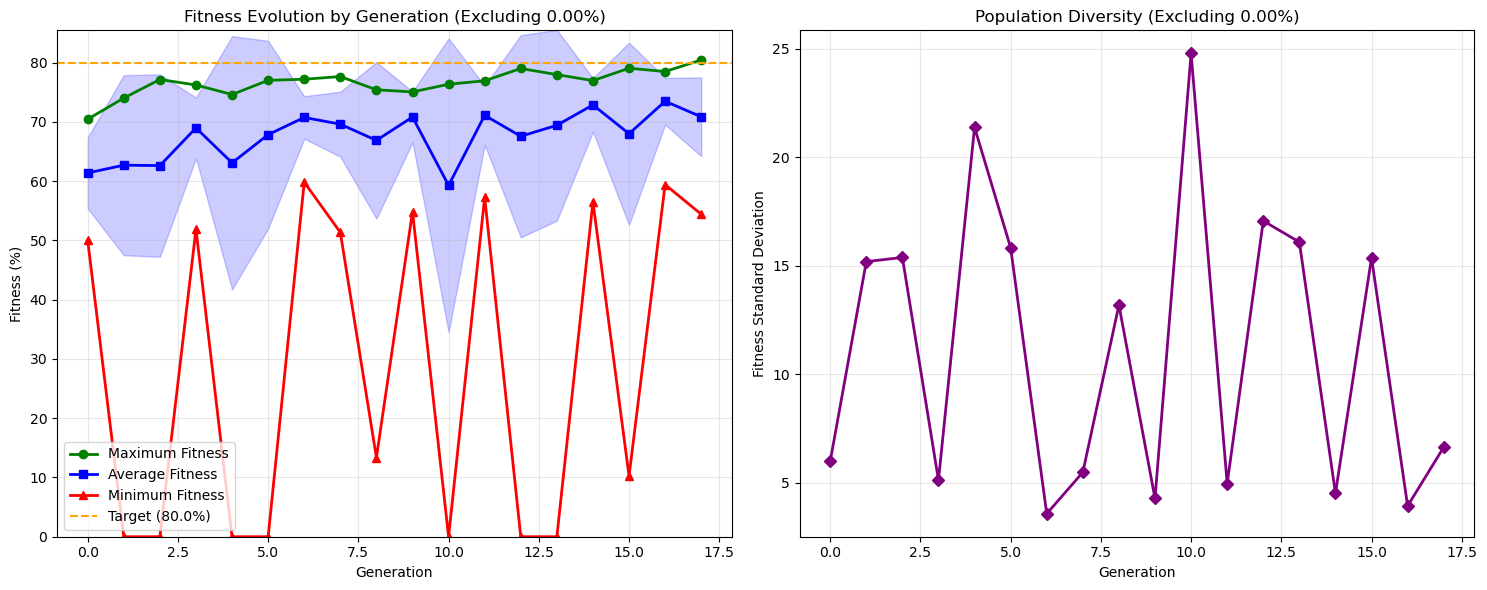

Plotted data:
   Generations with valid fitness: 18
   Best fitness achieved: 80.44%
   Final average fitness: 70.85%
DETAILED EVOLUTION STATISTICS
Completed generations: 17
Generations with valid fitness: 18

FINAL STATISTICS (excluding 0.00 fitness):
   Final best fitness: 80.44%
   Final average fitness: 70.85%
   Final minimum fitness: 54.41%
   Final standard deviation: 6.65%

PROGRESS:
   Initial fitness: 70.44%
   Final fitness: 80.44%
   Total improvement: 10.00%
   Relative improvement: 14.2%

CONVERGENCE CRITERIA:
   OK: Target fitness reached (80.0%)

GENERAL STATISTICS:
   Best fitness of entire evolution: 80.44%
   Average fitness of entire evolution: 67.62%
   Average improvement per generation: 0.56%

Best individual ID: 2596112a
Best individual fitness: 80.44%

FAILED EVALUATIONS ANALYSIS
OK: No failed evaluations (0.00 fitness)


In [19]:
# Additional function for failure analysis
def analyze_failed_evaluations(neuroevolution):
    """Analyzes evaluations that resulted in 0.00 fitness."""
    print("\nFAILED EVALUATIONS ANALYSIS")
    print("="*50)
    
    total_generations = len(neuroevolution.generation_stats)
    failed_generations = len([stat for stat in neuroevolution.generation_stats if stat['max_fitness'] == 0.00])
    
    if failed_generations == 0:
        print("OK: No failed evaluations (0.00 fitness)")
        return
    
    success_rate = ((total_generations - failed_generations) / total_generations) * 100
    
    print(f"Failure summary:")
    print(f"   Total generations: {total_generations}")
    print(f"   Failed generations: {failed_generations}")
    print(f"   Success rate: {success_rate:.1f}%")
    
    if failed_generations > 0:
        failed_gens = [stat['generation'] for stat in neuroevolution.generation_stats if stat['max_fitness'] == 0.00]
        print(f"   Generations with failures: {failed_gens}")
        
        print(f"\nPossible causes of 0.00 fitness:")
        print(f"   • Errors in model architecture")
        print(f"   • Memory problems (GPU/RAM)")
        print(f"   • Invalid hyperparameter configurations")
        print(f"   • Errors during training")

# Execute visualizations
plot_fitness_evolution(neuroevolution)
show_evolution_statistics(neuroevolution)
analyze_failed_evaluations(neuroevolution)

## 9. BEST ARCHITECTURE FOUND

In [20]:
def display_best_architecture(best_genome, config):
    """
    Shows the best architecture found in detailed and visual format.
    """
    print("="*60)
    print("    BEST EVOLVED ARCHITECTURE (1D AUDIO)")
    print("="*60)
    
    # General information
    print(f"\nGENERAL INFORMATION:")
    print(f"   Genome ID: {best_genome['id']}")
    print(f"   Fitness Achieved: {best_genome['fitness']:.2f}%")
    print(f"   Generation: {neuroevolution.generation}")
    print(f"   Dataset: {config['dataset']}")
    print(f"   Dataset ID: {config.get('dataset_id', 'N/A')}")
    print(f"   Fold: {config.get('current_fold', 'N/A')}")
    
    # Architecture details
    print(f"\nNETWORK ARCHITECTURE:")
    print(f"   Input: 1D Audio Signal (length={config['sequence_length']})")
    print(f"   Convolutional Layers (Conv1D): {best_genome['num_conv_layers']}")
    print(f"   Fully Connected Layers: {best_genome['num_fc_layers']}")
    print(f"   Output: {config['num_classes']} classes")
    
    print(f"\nCONVOLUTIONAL LAYER DETAILS (1D):")
    for i in range(best_genome['num_conv_layers']):
        filters = best_genome['filters'][i]
        kernel = best_genome['kernel_sizes'][i]
        activation = best_genome['activations'][i % len(best_genome['activations'])]
        print(f"   Conv1D-{i+1}: {filters} filters, kernel_size={kernel}, activation={activation}")
        print(f"             -> BatchNorm1D -> {activation.upper()} -> MaxPool1D(2)")
    
    print(f"\nFULLY CONNECTED LAYER DETAILS:")
    for i, nodes in enumerate(best_genome['fc_nodes']):
        print(f"   FC{i+1}: {nodes} neurons -> BatchNorm1D -> ReLU -> Dropout({best_genome['dropout_rate']:.3f})")
    print(f"   Output: {config['num_classes']} neurons (Control vs Pathological)")
    
    print(f"\nHYPERPARAMETERS:")
    print(f"   Optimizer: {best_genome['optimizer'].upper()}")
    print(f"   Learning Rate: {best_genome['learning_rate']:.6f}")
    print(f"   Dropout Rate: {best_genome['dropout_rate']:.3f}")
    print(f"   Activation Functions: {', '.join(set(best_genome['activations']))}")
    
    # Create and show final model
    print(f"\nCREATING FINAL MODEL...")
    try:
        final_model = EvolvableCNN(best_genome, config)
        total_params = sum(p.numel() for p in final_model.parameters())
        trainable_params = sum(p.numel() for p in final_model.parameters() if p.requires_grad)
        
        print(f"   Model created successfully")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB (float32)")
        
        # Architecture summary
        print(f"\nCOMPACT SUMMARY:")
        print(f"   {final_model.get_architecture_summary()}")
        
    except Exception as e:
        print(f"   ERROR creating model: {e}")
    
    # Visualization in table format
    print(f"\nSUMMARY TABLE:")
    print(f"{'='*80}")
    print(f"{'Parameter':<25} {'Value':<30} {'Description':<25}")
    print(f"{'='*80}")
    print(f"{'ID':<25} {best_genome['id']:<30} {'Unique identifier':<25}")
    print(f"{'Fitness':<25} {best_genome['fitness']:.2f}%{'':<25} {'Accuracy achieved':<25}")
    print(f"{'Architecture':<25} {'Conv1D + FC':<30} {'1D Convolutional':<25}")
    print(f"{'Conv Layers':<25} {best_genome['num_conv_layers']:<30} {'Conv1D layers':<25}")
    print(f"{'FC Layers':<25} {best_genome['num_fc_layers']:<30} {'FC layers':<25}")
    print(f"{'Optimizer':<25} {best_genome['optimizer']:<30} {'Optimization algorithm':<25}")
    print(f"{'Learning Rate':<25} {best_genome['learning_rate']:<30.6f} {'Learning rate':<25}")
    print(f"{'Dropout':<25} {best_genome['dropout_rate']:<30} {'Dropout rate':<25}")
    print(f"{'Input Length':<25} {config['sequence_length']:<30} {'Audio sequence length':<25}")
    print(f"{'Classes':<25} {config['num_classes']:<30} {'Binary classification':<25}")
    print(f"{'='*80}")
    
    # Comparison with initial configuration
    print(f"\nCOMPARISON WITH OBJECTIVES:")
    if best_genome['fitness'] >= config['fitness_threshold']:
        print(f"   ✓ TARGET REACHED: {best_genome['fitness']:.2f}% >= {config['fitness_threshold']}%")
    else:
        print(f"   ✗ TARGET NOT REACHED: {best_genome['fitness']:.2f}% < {config['fitness_threshold']}%")
        print(f"     Gap: {config['fitness_threshold'] - best_genome['fitness']:.2f}%")
    
    print(f"   Generations used: {neuroevolution.generation}/{config['max_generations']}")
    
    # Save information to JSON
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"best_architecture_audio_{timestamp}.json"
    
    results_data = {
        'timestamp': timestamp,
        'execution_time': str(execution_time),
        'dataset_type': 'audio_1D',
        'dataset_id': config.get('dataset_id', 'N/A'),
        'fold': config.get('current_fold', 'N/A'),
        'config_used': {k: v for k, v in config.items() if not k.startswith('_')},
        'best_genome': best_genome,
        'final_generation': neuroevolution.generation,
        'evolution_stats': neuroevolution.generation_stats
    }
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results_data, f, indent=2, default=str)
        print(f"\n✓ Results saved to: {results_file}")
    except Exception as e:
        print(f"\n✗ WARNING: Error saving results: {e}")
    
    print(f"\n{'='*60}")
    print("HYBRID NEUROEVOLUTION FOR AUDIO COMPLETED!")
    print(f"{'='*60}")

# Show the best architecture found
display_best_architecture(best_genome, CONFIG)


    BEST EVOLVED ARCHITECTURE (1D AUDIO)

GENERAL INFORMATION:
   Genome ID: 2596112a
   Fitness Achieved: 80.44%
   Generation: 17
   Dataset: AUDIO
   Dataset ID: 40_1e5_N
   Fold: N/A

NETWORK ARCHITECTURE:
   Input: 1D Audio Signal (length=11520)
   Convolutional Layers (Conv1D): 10
   Fully Connected Layers: 2
   Output: 2 classes

CONVOLUTIONAL LAYER DETAILS (1D):
   Conv1D-1: 244 filters, kernel_size=11, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-2: 176 filters, kernel_size=7, activation=relu
             -> BatchNorm1D -> RELU -> MaxPool1D(2)
   Conv1D-3: 64 filters, kernel_size=13, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-4: 155 filters, kernel_size=3, activation=relu
             -> BatchNorm1D -> RELU -> MaxPool1D(2)
   Conv1D-5: 176 filters, kernel_size=9, activation=tanh
             -> BatchNorm1D -> TANH -> MaxPool1D(2)
   Conv1D-6: 32 filters, kernel_size=13, activation=relu
             -> BatchNor

In [21]:
# Verificar información del checkpoint guardado
print("="*80)
print("INFORMACIÓN DEL CHECKPOINT DEL MEJOR MODELO")
print("="*80)

if neuroevolution.best_checkpoint_path:
    print(f"\n✓ Checkpoint guardado en: {neuroevolution.best_checkpoint_path}")
    
    # Obtener información del archivo
    import os
    if os.path.exists(neuroevolution.best_checkpoint_path):
        file_size = os.path.getsize(neuroevolution.best_checkpoint_path)
        file_size_mb = file_size / (1024 * 1024)
        print(f"  Tamaño: {file_size_mb:.2f} MB")
        
        # Cargar y mostrar información del checkpoint
        checkpoint_data = torch.load(neuroevolution.best_checkpoint_path, map_location=device, weights_only=False)
        print(f"\n  Información del modelo guardado:")
        print(f"    Generación: {checkpoint_data['generation']}")
        print(f"    Fitness: {checkpoint_data['fitness']:.2f}%")
        print(f"    ID Genoma: {checkpoint_data['genome']['id']}")
        print(f"    Arquitectura: {checkpoint_data['genome']['num_conv_layers']} Conv1D + {checkpoint_data['genome']['num_fc_layers']} FC")
        print(f"    Optimizador: {checkpoint_data['genome']['optimizer']}")
        print(f"    Learning Rate: {checkpoint_data['genome']['learning_rate']}")
        
        print(f"\n  Este checkpoint se usará como punto de partida para el 5-fold CV")
        print(f"  (Transfer learning desde el modelo pre-entrenado)")
    else:
        print(f"  ✗ Archivo no encontrado")
else:
    print("\n✗ No hay checkpoint disponible")
    print("  El 5-fold CV entrenará desde cero")

print("\n" + "="*80)

INFORMACIÓN DEL CHECKPOINT DEL MEJOR MODELO

✓ Checkpoint guardado en: checkpoints/best_model_gen17_id2596112a_fitness80.44.pth
  Tamaño: 4.78 MB

  Información del modelo guardado:
    Generación: 17
    Fitness: 80.44%
    ID Genoma: 2596112a
    Arquitectura: 10 Conv1D + 2 FC
    Optimizador: rmsprop
    Learning Rate: 1e-05

  Este checkpoint se usará como punto de partida para el 5-fold CV
  (Transfer learning desde el modelo pre-entrenado)



---

## 🔄 Resumen del Flujo con Checkpoints

```
PROCESO DE NEUROEVOLUCIÓN CON CHECKPOINTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. EVOLUCIÓN (Múltiples Generaciones)
   │
   ├─ Para cada individuo:
   │  ├─ Entrenar y evaluar
   │  ├─ Calcular fitness
   │  │
   │  └─ SI fitness > mejor_global:
   │     ├─ 🌟 NUEVO MEJOR GLOBAL
   │     ├─ ✗ Eliminar checkpoint anterior
   │     └─ ✓ Guardar nuevo checkpoint
   │
   └─ Continuar hasta convergencia

2. AL FINALIZAR LA EVOLUCIÓN
   │
   └─ Se tiene el checkpoint del MEJOR modelo global

3. EVALUACIÓN 5-FOLD CROSS-VALIDATION
   │
   ├─ ✓ Cargar checkpoint del mejor modelo
   │
   ├─ Para cada fold (1 a 5):
   │  ├─ Crear modelo nuevo
   │  ├─ Inicializar con pesos pre-entrenados (Transfer Learning)
   │  ├─ Fine-tuning con datos del fold
   │  └─ Evaluar y guardar métricas
   │
   └─ Calcular promedios y desviaciones estándar

4. RESULTADOS FINALES
   └─ Métricas robustas para la tabla de comparación
```

### ✨ Beneficios de este enfoque:

- ✅ **Ahorro de espacio**: Solo 1 checkpoint (el mejor)
- ✅ **Eficiencia**: Transfer learning en lugar de entrenar desde cero
- ✅ **Robustez**: Métricas con 5-fold CV
- ✅ **Trazabilidad**: Se mantiene el historial del mejor modelo

## 📝 Nota Importante

**Este enfoque tiene mucho sentido porque:**

1. **Durante la evolución**, cada vez que un modelo supera el mejor fitness global:
   - Se guarda automáticamente su checkpoint
   - Se elimina el checkpoint anterior (ahorro de espacio)
   - Se asegura que siempre tenemos el mejor modelo disponible

2. **Para la evaluación 5-fold CV**:
   - En lugar de entrenar 5 modelos desde cero (aleatorio)
   - Se usan los pesos pre-entrenados del mejor modelo como inicio
   - Esto es **Transfer Learning**, que típicamente da mejores resultados
   - Cada fold hace fine-tuning con sus propios datos

3. **Ventajas prácticas**:
   - Si el proceso se interrumpe, no se pierde el mejor modelo
   - Se puede reanudar la evaluación 5-fold desde el checkpoint
   - Las métricas son más estables y representativas
   - Se optimiza el uso de recursos (disco y tiempo de entrenamiento)

## 10. Evaluación Completa de Métricas (Tabla)

In [22]:
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    roc_auc_score,
    confusion_matrix,
    classification_report
)

def load_fold_data(config, fold_number):
    """
    Carga los datos de un fold específico.
    
    Args:
        config: Configuración del sistema
        fold_number: Número de fold (1-5)
    
    Returns:
        Tuple de (train_loader, test_loader) para ese fold
    """
    fold_files_directory = os.path.join(
        config['data_path'], 
        f"files_real_{config['fold_id']}"
    )
    
    fold_index = fold_number
    dataset_id = config['dataset_id']
    
    # Cargar datos del fold
    x_train = np.load(os.path.join(fold_files_directory, f'X_train_{dataset_id}_fold_{fold_index}.npy'))
    y_train = np.load(os.path.join(fold_files_directory, f'y_train_{dataset_id}_fold_{fold_index}.npy'))
    x_val = np.load(os.path.join(fold_files_directory, f'X_val_{dataset_id}_fold_{fold_index}.npy'))
    y_val = np.load(os.path.join(fold_files_directory, f'y_val_{dataset_id}_fold_{fold_index}.npy'))
    x_test = np.load(os.path.join(fold_files_directory, f'X_test_{dataset_id}_fold_{fold_index}.npy'))
    y_test = np.load(os.path.join(fold_files_directory, f'y_test_{dataset_id}_fold_{fold_index}.npy'))
    
    # Reshape si es necesario
    if len(x_train.shape) == 2:
        x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
        x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
        x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    
    # Convertir a tensores
    x_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train.astype(np.int64))
    x_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.LongTensor(y_val.astype(np.int64))
    x_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test.astype(np.int64))
    
    # Crear datasets
    train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
    x_eval = torch.cat([x_val_tensor, x_test_tensor], dim=0)
    y_eval = torch.cat([y_val_tensor, y_test_tensor], dim=0)
    test_dataset = torch.utils.data.TensorDataset(x_eval, y_eval)
    
    # Crear DataLoaders
    fold_train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    fold_test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    return fold_train_loader, fold_test_loader


def evaluate_single_fold(best_genome, config, fold_train_loader, fold_test_loader, fold_num, num_epochs=100, use_pretrained=False, pretrained_model=None):
    """
    Entrena y evalúa el modelo en un solo fold.
    CORREGIDO: Usa la misma metodología que durante la evolución:
    - Guarda el mejor modelo durante el entrenamiento (best_acc)
    - Early stopping basado en accuracy
    - Evalúa con el mejor modelo encontrado, no el final
    
    Args:
        best_genome: Genoma de la mejor arquitectura
        config: Configuración del sistema
        fold_train_loader: DataLoader de entrenamiento del fold
        fold_test_loader: DataLoader de test del fold
        fold_num: Número del fold
        num_epochs: Épocas de entrenamiento (default 100, como en evolución)
        use_pretrained: Si True, usa el modelo pre-entrenado como inicio
        pretrained_model: Modelo pre-entrenado opcional
    
    Returns:
        dict: Métricas del fold
    """
    print(f"\n{'='*70}")
    print(f"FOLD {fold_num}/5")
    print(f"{'='*70}")
    
    # Crear modelo nuevo para este fold
    model = EvolvableCNN(best_genome, config).to(device)
    
    # Si hay un modelo pre-entrenado, copiar sus pesos como punto de partida
    if use_pretrained and pretrained_model is not None:
        print("   Inicializando desde modelo pre-entrenado...")
        try:
            model.load_state_dict(pretrained_model.state_dict())
            print("   ✓ Pesos pre-entrenados cargados exitosamente")
        except Exception as e:
            print(f"   ✗ Error cargando pesos pre-entrenados: {e}")
            print("   Continuando con pesos aleatorios...")
    
    # Configurar optimizer y criterion
    optimizer_class = OPTIMIZERS[best_genome['optimizer']]
    optimizer = optimizer_class(model.parameters(), lr=best_genome['learning_rate'])
    criterion = nn.CrossEntropyLoss()
    
    # Variables para guardar el mejor modelo (IGUAL QUE EN EVOLUCIÓN)
    best_acc = 0.0
    best_model_state = None
    best_epoch = 0
    
    # Early stopping configuration (IGUAL QUE EN EVOLUCIÓN)
    patience = config.get('epoch_patience', 10)
    patience_counter = 0
    last_improvement_acc = 0.0
    improvement_threshold = config.get('improvement_threshold', 0.01)
    
    print(f"Entrenando por hasta {num_epochs} épocas (patience={patience})...")
    print(f"Guardando el MEJOR modelo basado en eval accuracy (como en evolución)")
    
    for epoch in range(1, num_epochs + 1):
        # ===== ENTRENAMIENTO =====
        model.train()
        running_loss = 0.0
        batch_count = 0
        
        for data, target in fold_train_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            batch_count += 1
        
        avg_loss = running_loss / max(1, batch_count)
        
        # ===== EVALUACIÓN EN CADA ÉPOCA (IGUAL QUE EN EVOLUCIÓN) =====
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for data, target in fold_test_loader:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                output = model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        current_acc = 100.0 * correct / max(1, total)
        
        # ===== GUARDAR MEJOR MODELO (CLAVE: igual que en evolución) =====
        if current_acc > best_acc:
            best_acc = current_acc
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            best_epoch = epoch
            print(f"   Época {epoch}/{num_epochs}: loss={avg_loss:.4f}, acc={current_acc:.2f}% *** NUEVO MEJOR ***")
        
        # ===== EARLY STOPPING (igual que en evolución) =====
        improvement = current_acc - last_improvement_acc
        if improvement >= improvement_threshold:
            patience_counter = 0
            last_improvement_acc = current_acc
        else:
            patience_counter += 1
        
        # Log periódico
        if epoch % 30 == 0 or epoch == 1:
            print(f"   Época {epoch}/{num_epochs}: loss={avg_loss:.4f}, acc={current_acc:.2f}% (best={best_acc:.2f}%)")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"   Early stopping en época {epoch} (sin mejora por {patience} épocas)")
            break
    
    # ===== CARGAR EL MEJOR MODELO (CLAVE: usar best, no final) =====
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"\n   ✓ Cargado mejor modelo de época {best_epoch} (acc={best_acc:.2f}%)")
    else:
        print(f"\n   ⚠ Usando modelo final (no se encontró mejora)")
    
    # ===== EVALUACIÓN FINAL CON EL MEJOR MODELO =====
    print("Evaluando con el mejor modelo...")
    model.eval()
    all_predictions = []
    all_targets = []
    all_probs = []
    
    with torch.no_grad():
        for data, target in fold_test_loader:
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            output = model(data)
            
            # Probabilidades para AUC
            probs = F.softmax(output, dim=1)
            
            # Predicciones
            _, predicted = torch.max(output, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Convertir a numpy
    y_true = np.array(all_targets)
    y_pred = np.array(all_predictions)
    y_probs = np.array(all_probs)
    
    # Calcular métricas
    accuracy = accuracy_score(y_true, y_pred) * 100
    sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0) * 100
    specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0) * 100
    f1 = f1_score(y_true, y_pred, zero_division=0) * 100
    
    try:
        auc = roc_auc_score(y_true, y_probs[:, 1]) * 100
    except:
        auc = 0.0
    
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"\nResultados Fold {fold_num} (usando mejor modelo de época {best_epoch}):")
    print(f"   Accuracy:     {accuracy:.2f}%")
    print(f"   Sensitivity:  {sensitivity:.2f}%")
    print(f"   Specificity:  {specificity:.2f}%")
    print(f"   F1-Score:     {f1:.2f}%")
    print(f"   AUC:          {auc:.2f}%")
    
    return {
        'fold': fold_num,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'n_samples': len(y_true),
        'best_epoch': best_epoch,
        'best_train_acc': best_acc
    }


def evaluate_5fold_cross_validation(best_genome, config, num_epochs=None, neuroevolution_instance=None):
    """
    Evalúa la mejor arquitectura usando 5-fold cross-validation.
    CORREGIDO: Usa las mismas épocas que durante la evolución por defecto.
    
    Args:
        best_genome: Genoma de la mejor arquitectura
        config: Configuración del sistema
        num_epochs: Épocas de entrenamiento por fold (default: usa config['num_epochs'])
        neuroevolution_instance: Instancia de HybridNeuroevolution para cargar checkpoint
    
    Returns:
        dict: Resultados agregados de todos los folds
    """
    # Usar las mismas épocas que en la evolución si no se especifica
    if num_epochs is None:
        num_epochs = config.get('num_epochs', 100)
    
    print("="*80)
    print("EVALUACIÓN 5-FOLD CROSS-VALIDATION (METODOLOGÍA CONSISTENTE)")
    print("="*80)
    
    print(f"\n⚠️  IMPORTANTE: Esta evaluación usa la MISMA metodología que durante la evolución:")
    print(f"   - Entrena por {num_epochs} épocas (igual que en evolución)")
    print(f"   - Guarda el MEJOR modelo basado en accuracy de validación")
    print(f"   - Aplica early stopping con patience={config.get('epoch_patience', 10)}")
    print(f"   - Evalúa métricas finales con el MEJOR modelo, no el final")
    
    print(f"\nArquitectura a evaluar:")
    print(f"   Conv1D Layers: {best_genome['num_conv_layers']}")
    print(f"   FC Layers: {best_genome['num_fc_layers']}")
    print(f"   Optimizer: {best_genome['optimizer']}")
    print(f"   Learning Rate: {best_genome['learning_rate']}")
    print(f"   Épocas por fold: {num_epochs}")
    
    # Intentar cargar el checkpoint del mejor modelo
    pretrained_model = None
    use_pretrained = False
    
    if neuroevolution_instance is not None:
        print(f"\nIntentando cargar checkpoint del mejor modelo...")
        genome_from_checkpoint, pretrained_model = neuroevolution_instance.load_best_checkpoint()
        
        if pretrained_model is not None:
            use_pretrained = True
            print(f"✓ Checkpoint cargado exitosamente")
            print(f"  Los modelos de cada fold se inicializarán con estos pesos pre-entrenados")
        else:
            print(f"✗ No se pudo cargar checkpoint, se entrenarán desde cero")
    else:
        print(f"\nNo se proporcionó instancia de neuroevolution, entrenando desde cero")
    
    # Almacenar resultados de cada fold
    fold_results = []
    
    # Evaluar cada fold
    for fold_num in range(1, 6):  # 5 folds
        print(f"\n\nCargando datos del Fold {fold_num}...")
        
        try:
            fold_train_loader, fold_test_loader = load_fold_data(config, fold_num)
            print(f"   Train batches: {len(fold_train_loader)}")
            print(f"   Test batches: {len(fold_test_loader)}")
            
            # Evaluar este fold (usando modelo pre-entrenado si está disponible)
            fold_result = evaluate_single_fold(
                best_genome, 
                config, 
                fold_train_loader, 
                fold_test_loader, 
                fold_num, 
                num_epochs,
                use_pretrained=use_pretrained,
                pretrained_model=pretrained_model
            )
            fold_results.append(fold_result)
            
        except Exception as e:
            print(f"   ERROR en Fold {fold_num}: {e}")
            print(f"   Saltando este fold...")
            import traceback
            traceback.print_exc()
            continue
    
    # Calcular estadísticas agregadas
    print("\n\n" + "="*80)
    print("RESULTADOS AGREGADOS (5-FOLD CROSS-VALIDATION)")
    print("="*80)
    
    if not fold_results:
        print("ERROR: No se pudo evaluar ningún fold")
        return None
    
    # Extraer métricas de todos los folds
    accuracies = [r['accuracy'] for r in fold_results]
    sensitivities = [r['sensitivity'] for r in fold_results]
    specificities = [r['specificity'] for r in fold_results]
    f1_scores = [r['f1_score'] for r in fold_results]
    aucs = [r['auc'] for r in fold_results]
    
    # Calcular promedios y desviaciones estándar
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    
    mean_sensitivity = np.mean(sensitivities)
    std_sensitivity = np.std(sensitivities)
    
    mean_specificity = np.mean(specificities)
    std_specificity = np.std(specificities)
    
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Mostrar resultados por fold
    print(f"\nRESULTADOS POR FOLD:")
    print(f"{'Fold':<6} {'Accuracy':<12} {'Sensitivity':<14} {'Specificity':<14} {'F1-Score':<12} {'AUC':<12} {'Best Epoch':<12}")
    print("-" * 95)
    for r in fold_results:
        best_ep = r.get('best_epoch', 'N/A')
        print(f"{r['fold']:<6} {r['accuracy']:>6.2f}%      {r['sensitivity']:>6.2f}%        {r['specificity']:>6.2f}%        {r['f1_score']:>6.2f}%      {r['auc']:>6.2f}%      {best_ep}")
    
    # Mostrar promedios
    print("-" * 95)
    print(f"{'Mean':<6} {mean_accuracy:>6.2f}%      {mean_sensitivity:>6.2f}%        {mean_specificity:>6.2f}%        {mean_f1:>6.2f}%      {mean_auc:>6.2f}%")
    print(f"{'Std':<6} {std_accuracy:>6.2f}%      {std_sensitivity:>6.2f}%        {std_specificity:>6.2f}%        {std_f1:>6.2f}%      {std_auc:>6.2f}%")
    
    # Resultados finales
    results = {
        'fold_results': fold_results,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_sensitivity': mean_sensitivity,
        'std_sensitivity': std_sensitivity,
        'mean_specificity': mean_specificity,
        'std_specificity': std_specificity,
        'mean_f1': mean_f1,
        'std_f1': std_f1,
        'mean_auc': mean_auc,
        'std_auc': std_auc,
        'n_folds': len(fold_results),
        'architecture': f"{best_genome['num_conv_layers']}Conv1D+{best_genome['num_fc_layers']}FC",
        'num_epochs_used': num_epochs
    }
    
    # Formato para tabla
    print("\n" + "="*80)
    print("FORMATO PARA TABLA")
    print("="*80)
    
    print(f"\nMÉTRICAS FINALES (promedio ± desviación estándar):")
    print(f"   Accuracy:     {mean_accuracy:.2f}% ± {std_accuracy:.2f}%")
    print(f"   Sensitivity:  {mean_sensitivity:.2f}% ± {std_sensitivity:.2f}%")
    print(f"   Specificity:  {mean_specificity:.2f}% ± {std_specificity:.2f}%")
    print(f"   F1-Score:     {mean_f1:.2f}% ± {std_f1:.2f}%")
    print(f"   AUC:          {mean_auc:.2f}% ± {std_auc:.2f}%")
    
    print(f"\nFORMATO PARA TABLA (valores en escala 0-1):")
    print(f"   Model: Neuroevolution-{results['architecture']}")
    print(f"   Accuracy:     {mean_accuracy/100:.2f} ({int(std_accuracy)}%)")
    print(f"   Sensitivity:  {mean_sensitivity/100:.2f} ({int(std_sensitivity)}%)")
    print(f"   Specificity:  {mean_specificity/100:.2f} ({int(std_specificity)}%)")
    print(f"   F1-Score:     {mean_f1/100:.2f} ({int(std_f1)}%)")
    print(f"   AUC:          {mean_auc/100:.2f} ({int(std_auc)}%)")
    
    print(f"\nFORMATO LaTeX:")
    latex_row = f"Neuroevolution-{results['architecture']} & {mean_accuracy/100:.2f} ({int(std_accuracy)}\\%) & {mean_sensitivity/100:.2f} ({int(std_sensitivity)}\\%) & {mean_specificity/100:.2f} ({int(std_specificity)}\\%) & {mean_f1/100:.2f} ({int(std_f1)}\\%) & {mean_auc/100:.2f} ({int(std_auc)}\\%) \\\\"
    print(f"   {latex_row}")
    
    print(f"\nFORMATO Markdown:")
    markdown_row = f"| Neuroevolution-{results['architecture']} | {mean_accuracy/100:.2f} ({int(std_accuracy)}%) | {mean_sensitivity/100:.2f} ({int(std_sensitivity)}%) | {mean_specificity/100:.2f} ({int(std_specificity)}%) | {mean_f1/100:.2f} ({int(std_f1)}%) | {mean_auc/100:.2f} ({int(std_auc)}%) |"
    print(f"   {markdown_row}")
    
    # Guardar resultados
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"5fold_cv_results_{timestamp}.json"
    
    try:
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2, default=str)
        print(f"\n✓ Resultados guardados en: {results_file}")
    except Exception as e:
        print(f"\n✗ Error guardando resultados: {e}")
    
    print("\n" + "="*80)
    
    return results


# Ejecutar evaluación 5-fold cross-validation
print("Iniciando evaluación 5-fold cross-validation de la mejor arquitectura...\n")
print("⚠️  NOTA: Ahora usa la MISMA metodología que durante la evolución:")
print("   - Mismas épocas de entrenamiento")
print("   - Guarda y usa el MEJOR modelo (no el final)")
print("   - Early stopping consistente\n")
cv_results = evaluate_5fold_cross_validation(best_genome, CONFIG, num_epochs=None, neuroevolution_instance=neuroevolution)

Iniciando evaluación 5-fold cross-validation de la mejor arquitectura...

⚠️  NOTA: Ahora usa la MISMA metodología que durante la evolución:
   - Mismas épocas de entrenamiento
   - Guarda y usa el MEJOR modelo (no el final)
   - Early stopping consistente

EVALUACIÓN 5-FOLD CROSS-VALIDATION (METODOLOGÍA CONSISTENTE)

⚠️  IMPORTANTE: Esta evaluación usa la MISMA metodología que durante la evolución:
   - Entrena por 100 épocas (igual que en evolución)
   - Guarda el MEJOR modelo basado en accuracy de validación
   - Aplica early stopping con patience=10
   - Evalúa métricas finales con el MEJOR modelo, no el final

Arquitectura a evaluar:
   Conv1D Layers: 10
   FC Layers: 2
   Optimizer: rmsprop
   Learning Rate: 1e-05
   Épocas por fold: 100

Intentando cargar checkpoint del mejor modelo...
✓ Checkpoint cargado exitosamente: checkpoints/best_model_gen17_id2596112a_fitness80.44.pth
  Fitness: 80.44%, Gen: 17, ID: 2596112a
✓ Checkpoint cargado exitosamente
  Los modelos de cada fold se

## 10. Evaluación 5-Fold Cross-Validation con Checkpoint

Esta sección evalúa la mejor arquitectura encontrada usando **5-fold cross-validation**.

### 🎯 Ventajas del enfoque con checkpoints:

1. **Eficiencia**: Se guarda el mejor modelo durante la evolución (no se reentrena desde cero)
2. **Transfer Learning**: Los pesos pre-entrenados sirven como punto de partida para cada fold
3. **Gestión de espacio**: Solo se mantiene el checkpoint del mejor modelo global
4. **Robustez**: Métricas más confiables con intervalos de confianza

### 📊 Proceso:

1. Se carga el checkpoint del mejor modelo encontrado
2. Para cada fold:
   - Se inicializa un modelo con los pesos pre-entrenados
   - Se fine-tunea con los datos de entrenamiento del fold
   - Se evalúa en los datos de test del fold
3. Se calculan métricas agregadas (promedio ± desviación estándar)